In [355]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import seaborn.objects as so
import json
import plotly.express as px
from formulaic import Formula
from sklearn import linear_model  
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error  
import unicodedata
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

from sklearn.preprocessing import PolynomialFeatures    # Herramientas de polinomios

from sklearn.model_selection import train_test_split, KFold, cross_val_score

**ANALISIS EXPLORATORIO POR ZONA 2022**

In [356]:
df_educacion = pd.read_csv(r"G:\Mi unidad\Proyecto Repitencia\indicadores-proceso-trayectoria-sobreedad-2012_2022.csv")
df_poblacion=pd.read_csv(r"G:\Mi unidad\Proyecto Repitencia\proyecciones-poblacion-2010_2025.csv")
df_transferencias=pd.read_csv(r"G:\Mi unidad\Proyecto Repitencia\transferencias-municipios-012010_072025.csv")
df_servicio=pd.read_csv(r"G:\Mi unidad\Proyecto Repitencia\evolucion-unidades-de-servicio-y-matricula-2011_2023.csv")

In [357]:
area_metropolitana = [
    "Almirante Brown", "Avellaneda", "Berazategui", "Berisso", "Brandsen", "Campana", "Cañuelas",
    "Ensenada", "Escobar", "Esteban Echeverria", "Exaltacion de la Cruz", "Ezeiza",
    "Florencio Varela", "General Las Heras", "General Rodriguez", "General San Martin", "Hurlingham",
    "Ituzaingo", "Jose C. Paz", "La Matanza", "La Plata", "Lanus", "Lujan", "Lomas de Zamora",
    "Malvinas Argentinas", "Marcos Paz", "Merlo", "Moreno", "Moron", "Pilar", "Presidente Peron",
    "Quilmes", "San Fernando", "San Isidro", "San Miguel", "San Vicente", "Tigre", "Tres de Febrero",
    "Vicente Lopez", "Zarate"
]

zona_norte = ['San Isidro', 'Vicente Lopez', 'General San Martin', 'San Fernando', 'Tigre']
zona_oeste = ['Moron', 'Tres de Febrero', 'La Matanza', 'Merlo', 'Moreno']
zona_sur = ['Almirante Brown', 'Avellaneda', 'Quilmes', 'Lanus', 'Florencio Varela', 'Berazategui', 'Lomas de Zamora', 'Esteban Echeverria']

In [358]:
df_educacion=df_educacion[df_educacion["municipio_nombre"].isin(area_metropolitana)].reset_index(drop=True)

def determinar_zona(x):
    if x in zona_norte:
        return 'Norte'
    elif x in zona_oeste:
        return 'Oeste'
    elif x in zona_sur:
        return 'Sur'
    else:
        return 'Interior'
    
df_educacion["Zona"]=df_educacion["municipio_nombre"].apply(determinar_zona)

In [359]:
df_analisis_2022=df_educacion[df_educacion["anio"]==2022]
#Transferencias

df_transferencias_2022=df_transferencias[df_transferencias["anio"]==2022]
df_transferencias_2022=df_transferencias_2022[df_transferencias_2022["municipio_nombre"].isin(area_metropolitana)]

transferencias_educacion=df_transferencias_2022[df_transferencias_2022["concepto"].isin(["Fondo Financiamiento Educativo"])]
transferencias_educacion=transferencias_educacion.rename(columns={"monto":"inversion_educacion"})
transferencias_educacion=transferencias_educacion[["municipio_nombre","inversion_educacion"]]

df_transferencias_2022=df_transferencias_2022[df_transferencias_2022["concepto"].isin(["Fondo Financiamiento Educativo","Fondo Inclusión Social","Fondo Infraestructura Municipal"])]
df_transferencias_2022=df_transferencias_2022.groupby("municipio_nombre")["monto"].sum().reset_index()
df_transferencias_2022=df_transferencias_2022.rename(columns={"monto":"inversion_total"})

df_transferencias_2022=pd.merge(df_transferencias_2022,transferencias_educacion,on="municipio_nombre",how="inner")

df_transferencias_2022


,municipio_nombre,inversion_total,inversion_educacion
0,Almirante Brown,1.137724e+09,1.182079e+08
1,Almirante Brown,1.137724e+09,1.296474e+08
2,Almirante Brown,1.137724e+09,1.334605e+08
3,Almirante Brown,1.137724e+09,7.626316e+07
4,Almirante Brown,1.137724e+09,8.007632e+07
...,...,...,...
275,Tres de Febrero,5.609013e+08,4.285460e+07
276,Tres de Febrero,5.609013e+08,4.285460e+07
277,Tres de Febrero,5.609013e+08,3.701079e+07
278,Tres de Febrero,5.609013e+08,4.090666e+07


*Preparación del Dataset*

In [360]:
df_analisis_2022=df_educacion[df_educacion["anio"]==2022]
#Transferencias

df_transferencias_2022=df_transferencias[df_transferencias["anio"]==2022]
df_transferencias_2022=df_transferencias_2022[df_transferencias_2022["municipio_nombre"].isin(area_metropolitana)]

transferencias_educacion=df_transferencias_2022[df_transferencias_2022["concepto"].isin(["Fondo Financiamiento Educativo"])]
transferencias_educacion=transferencias_educacion.rename(columns={"monto":"inversion_educacion"})
transferencias_educacion=transferencias_educacion[["municipio_nombre","inversion_educacion"]]

df_transferencias_2022=df_transferencias_2022.groupby("municipio_nombre")["monto"].sum().reset_index()
df_transferencias_2022=df_transferencias_2022.rename(columns={"monto":"inversion_total"})

df_transferencias_2022=pd.merge(df_transferencias_2022,transferencias_educacion,on="municipio_nombre",how="inner")


#Poblacion
df_poblacion_2022=df_poblacion[df_poblacion["municipio_nombre"].isin(area_metropolitana)]
df_poblacion_2022=df_poblacion_2022[["municipio_nombre","2022"]]
df_poblacion_2022=df_poblacion_2022.rename(columns={"2022":"poblacion"})

#Cantidad de colegios 
df_colegios_2022=df_servicio[df_servicio["municipio_nombre"].isin(area_metropolitana)]
df_colegios_2022=df_colegios_2022[df_colegios_2022["anio"]==2022]
df_colegios_2022=df_colegios_2022[["unidades_de_servicio_nivel_primario","matricula_nivel_primario*******","matricula_nivel_inicial","matricula_nivel_secundario********","unidades_de_servicio_nivel_secundario**","municipio_nombre"]]
df_colegios_2022=df_colegios_2022.rename(columns={"unidades_de_servicio_nivel_primario":"colegios_primario","unidades_de_servicio_nivel_secundario**":"colegios_secundario",
                                                  "matricula_nivel_primario*******":"matricula_primario","matricula_nivel_secundario********":"matricula_secundario"})

#Junto los data frame
df_analisis_2022=pd.merge(df_analisis_2022,df_transferencias_2022,on="municipio_nombre",how="inner")
df_analisis_2022=pd.merge(df_analisis_2022,df_poblacion_2022,on="municipio_nombre",how="inner")
df_analisis_2022=pd.merge(df_analisis_2022,df_colegios_2022,on="municipio_nombre",how="inner")

df_analisis_2022.head()


,anio,municipio_id,municipio_nombre,promocion_efectiva_primaria,promocion_efectiva_secundaria,repitencia_primaria,repitencia_secundaria,reinscripcion_primaria,reinscripcion_secundaria,abandono_interanual_primaria,...,sobreedad_avanzada_secundaria,Zona,inversion_total,inversion_educacion,poblacion,colegios_primario,matricula_primario,matricula_nivel_inicial,matricula_secundario,colegios_secundario
0,2022,6028,Almirante Brown,96.59,90.94,2.77,4.75,0.16,0.45,0.49,...,6.33,Sur,1.077158e+10,1.182079e+08,584827.0,137.0,61498.0,22523.0,52348.0,137.0
1,2022,6028,Almirante Brown,96.59,90.94,2.77,4.75,0.16,0.45,0.49,...,6.33,Sur,1.077158e+10,1.296474e+08,584827.0,137.0,61498.0,22523.0,52348.0,137.0
2,2022,6028,Almirante Brown,96.59,90.94,2.77,4.75,0.16,0.45,0.49,...,6.33,Sur,1.077158e+10,1.334605e+08,584827.0,137.0,61498.0,22523.0,52348.0,137.0
3,2022,6028,Almirante Brown,96.59,90.94,2.77,4.75,0.16,0.45,0.49,...,6.33,Sur,1.077158e+10,7.626316e+07,584827.0,137.0,61498.0,22523.0,52348.0,137.0
4,2022,6028,Almirante Brown,96.59,90.94,2.77,4.75,0.16,0.45,0.49,...,6.33,Sur,1.077158e+10,8.007632e+07,584827.0,137.0,61498.0,22523.0,52348.0,137.0


In [361]:
df_zonas_2022=df_analisis_2022.groupby("Zona")[["poblacion","matricula_nivel_inicial","matricula_primario","matricula_secundario","repitencia_primaria","repitencia_secundaria","inversion_educacion","inversion_total","colegios_primario","colegios_secundario","sobreedad_primaria","sobreedad_secundaria","sobreedad_avanzada_primaria","sobreedad_avanzada_secundaria"]].mean().reset_index()
df_zonas_2022

,Zona,poblacion,matricula_nivel_inicial,matricula_primario,matricula_secundario,repitencia_primaria,repitencia_secundaria,inversion_educacion,inversion_total,colegios_primario,colegios_secundario,sobreedad_primaria,sobreedad_secundaria,sobreedad_avanzada_primaria,sobreedad_avanzada_secundaria
0,Interior,203206.866667,8594.466667,22467.800000,18589.266667,2.019333,6.523333,3.593174e+07,5.055326e+09,57.600000,51.066667,4.068000,20.844667,0.637333,7.020667
1,Norte,305282.333333,12599.000000,29341.333333,26424.000000,1.460000,4.650000,4.245222e+07,7.305383e+09,85.333333,76.333333,3.320000,18.510000,0.503333,5.773333
2,Oeste,841135.250000,27003.000000,81654.750000,67260.000000,3.195000,5.762500,1.361237e+08,1.659346e+10,168.500000,160.000000,6.070000,20.765000,1.182500,6.595000
3,Sur,521899.500000,20032.333333,55117.500000,46624.833333,3.148333,6.611667,8.892495e+07,9.896553e+09,124.000000,118.333333,5.523333,22.770000,1.073333,8.103333


**CONTEXTO**

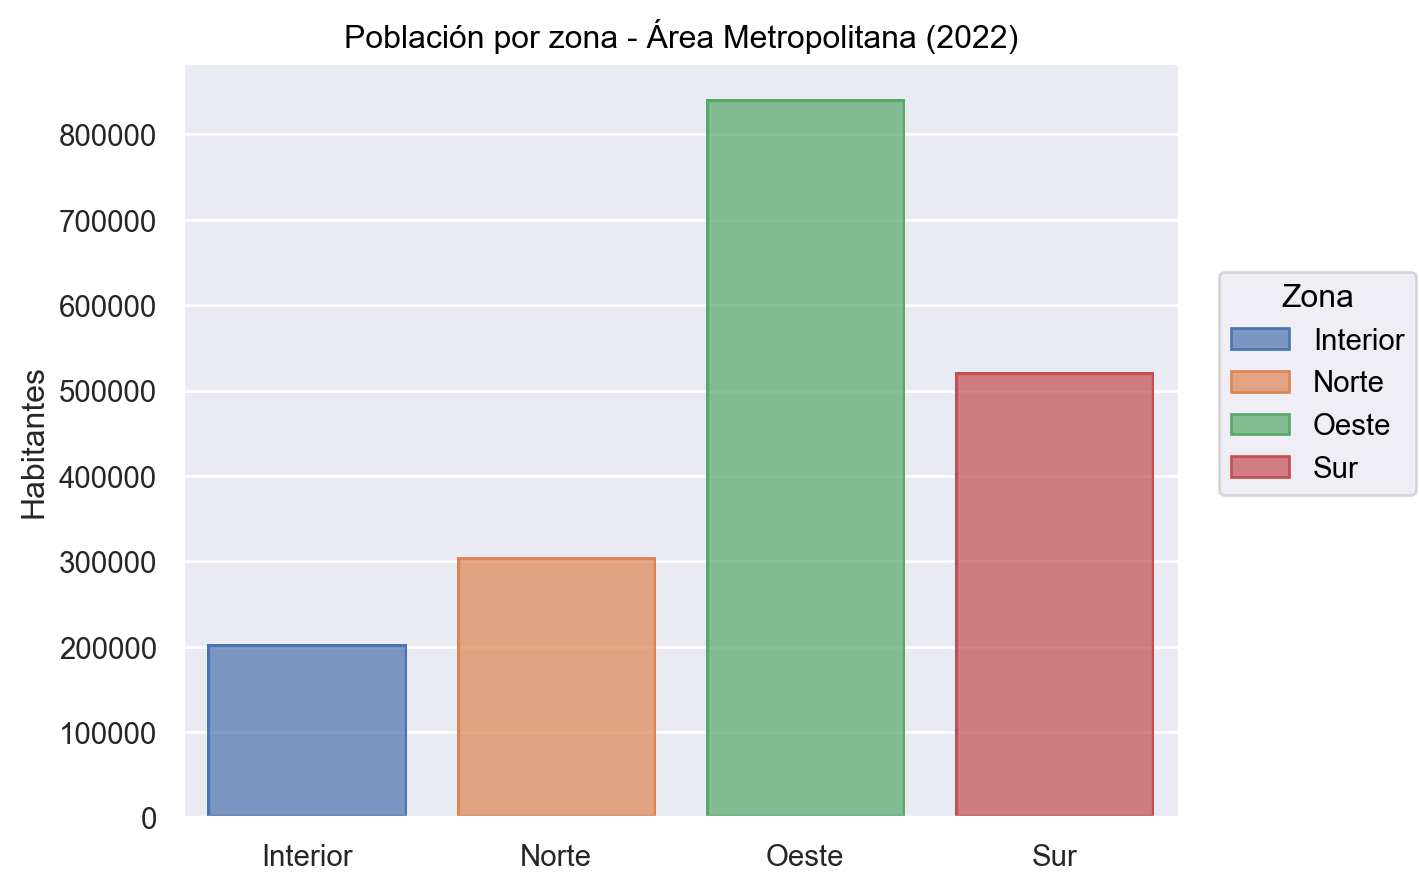

In [362]:
(so.Plot(df_zonas_2022,x="Zona",y="poblacion",color="Zona")
    .add(so.Bar())
    .label(title="Población por zona - Área Metropolitana (2022)",x=None,y="Habitantes"))

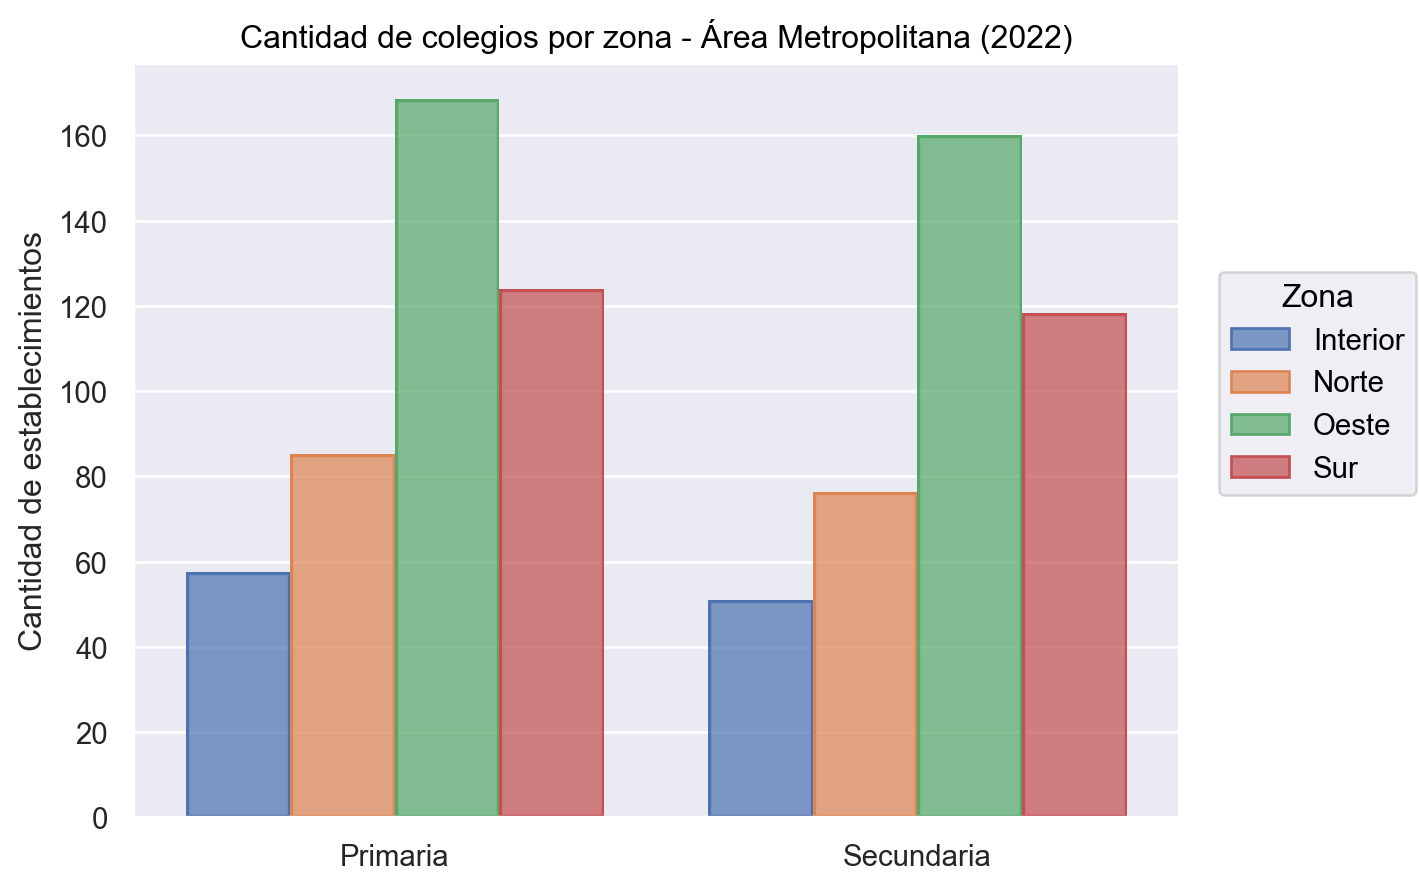

In [363]:
grafico_zona_colegio=df_zonas_2022.copy()
grafico_zona_colegio=grafico_zona_colegio.rename(columns={"colegios_primario":"Primaria","colegios_secundario":"Secundaria"})

grafico_zona_colegio=grafico_zona_colegio.melt(id_vars="Zona",
                                               value_vars=["Primaria","Secundaria"],
                                               var_name="Nivel",
                                               value_name="cantidad_colegios")

(so.Plot(grafico_zona_colegio,x="Nivel",y="cantidad_colegios",color="Zona")
    .add(so.Bar(),so.Dodge())
    .label(title="Cantidad de colegios por zona - Área Metropolitana (2022)",x=None,y="Cantidad de establecimientos"))

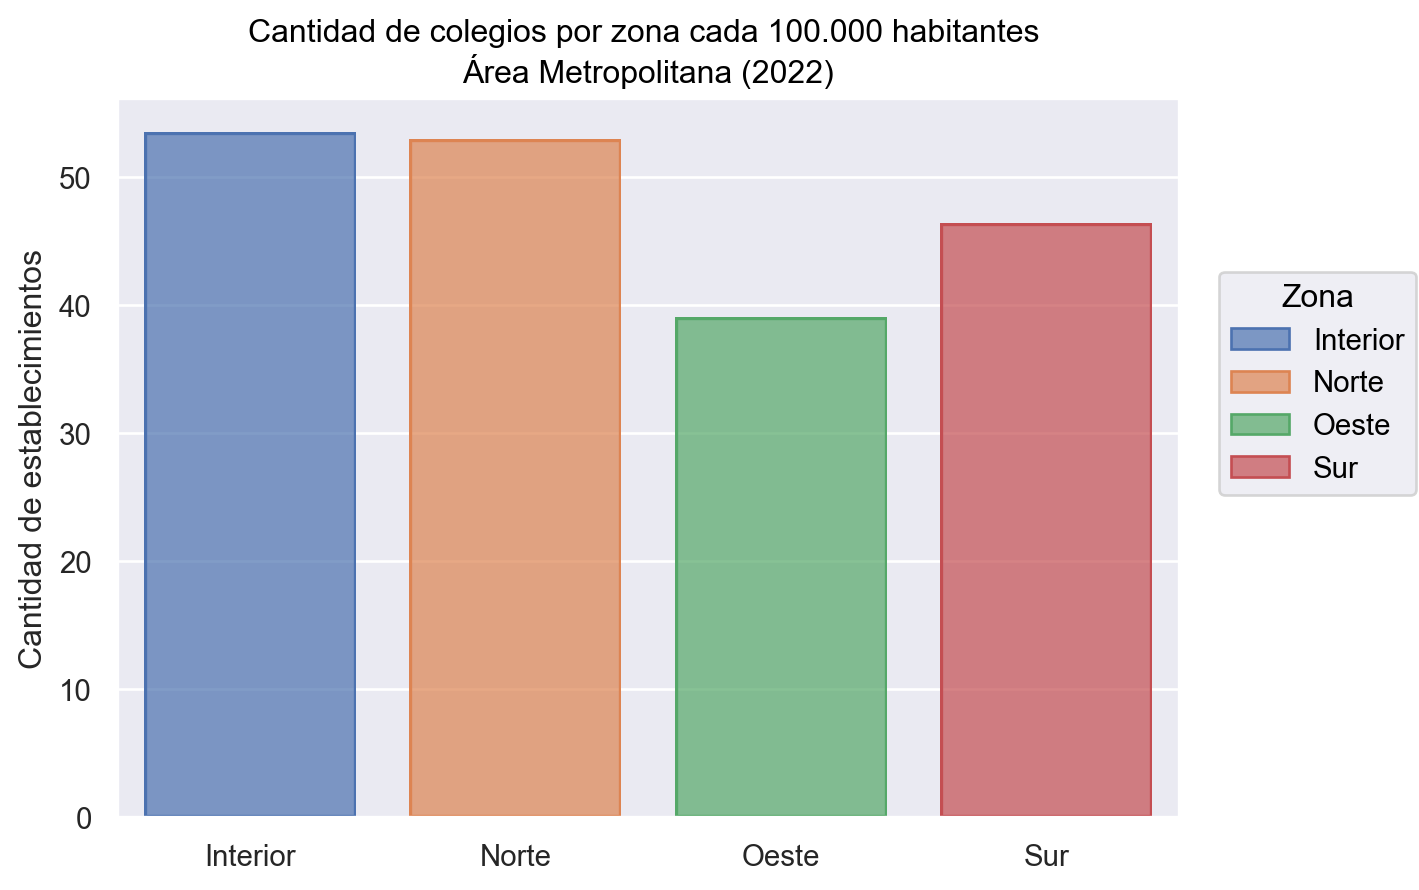

In [364]:
colegios_por_zona=((df_zonas_2022["colegios_secundario"]+df_zonas_2022["colegios_primario"])/df_zonas_2022["poblacion"])*100000

(so.Plot(df_zonas_2022,x="Zona",y=colegios_por_zona,color="Zona")
    .add(so.Bar())
    .label(title="Cantidad de colegios por zona cada 100.000 habitantes \nÁrea Metropolitana (2022)",x=None,y="Cantidad de establecimientos"))

***RECURSOS***

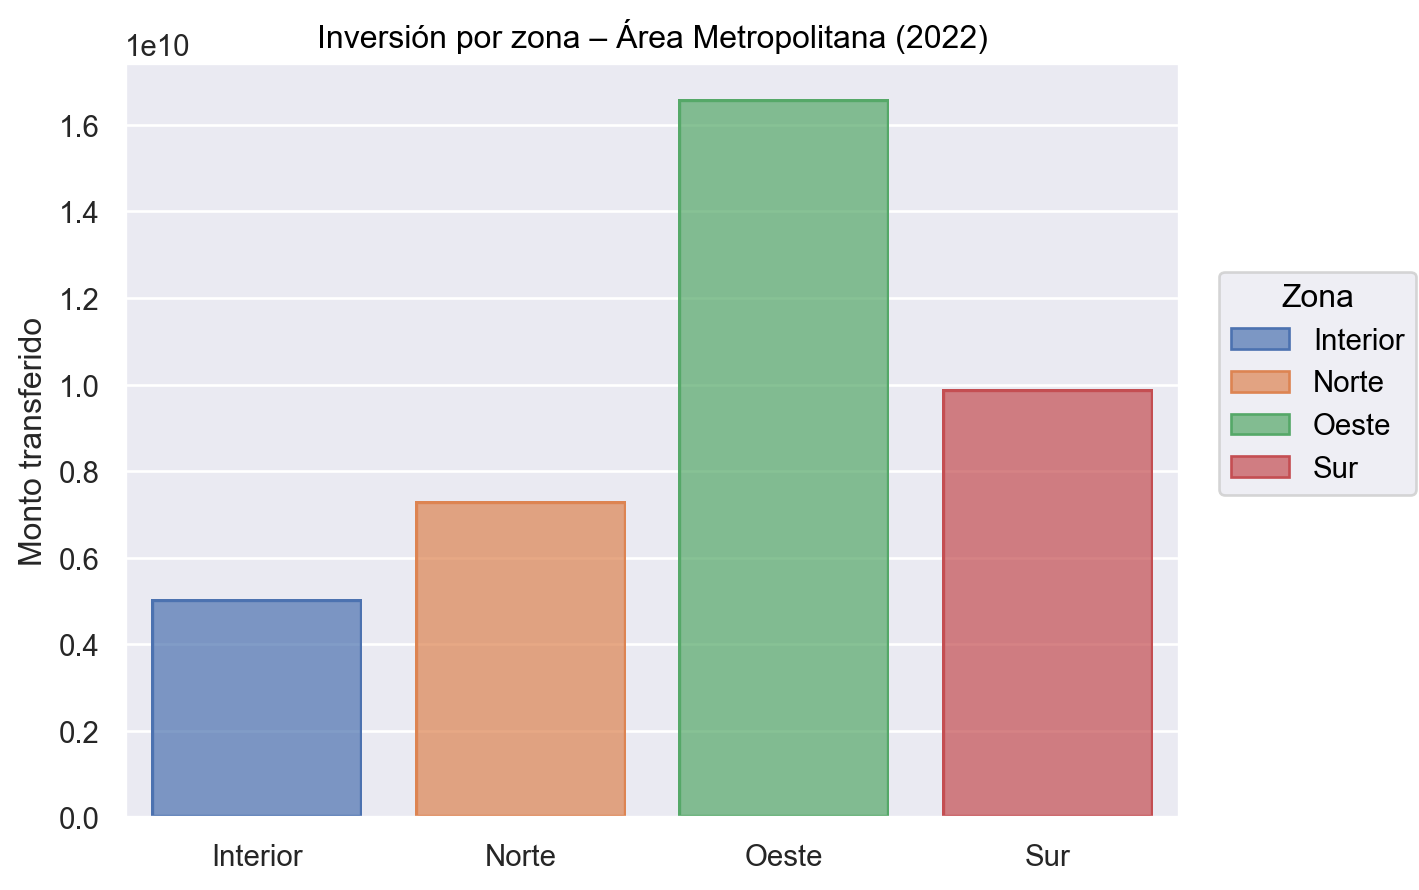

In [365]:
(so.Plot(df_zonas_2022,x="Zona",y="inversion_total",color="Zona")
    .add(so.Bar())
    .label(title="Inversión por zona – Área Metropolitana (2022)",x=None,y="Monto transferido"))

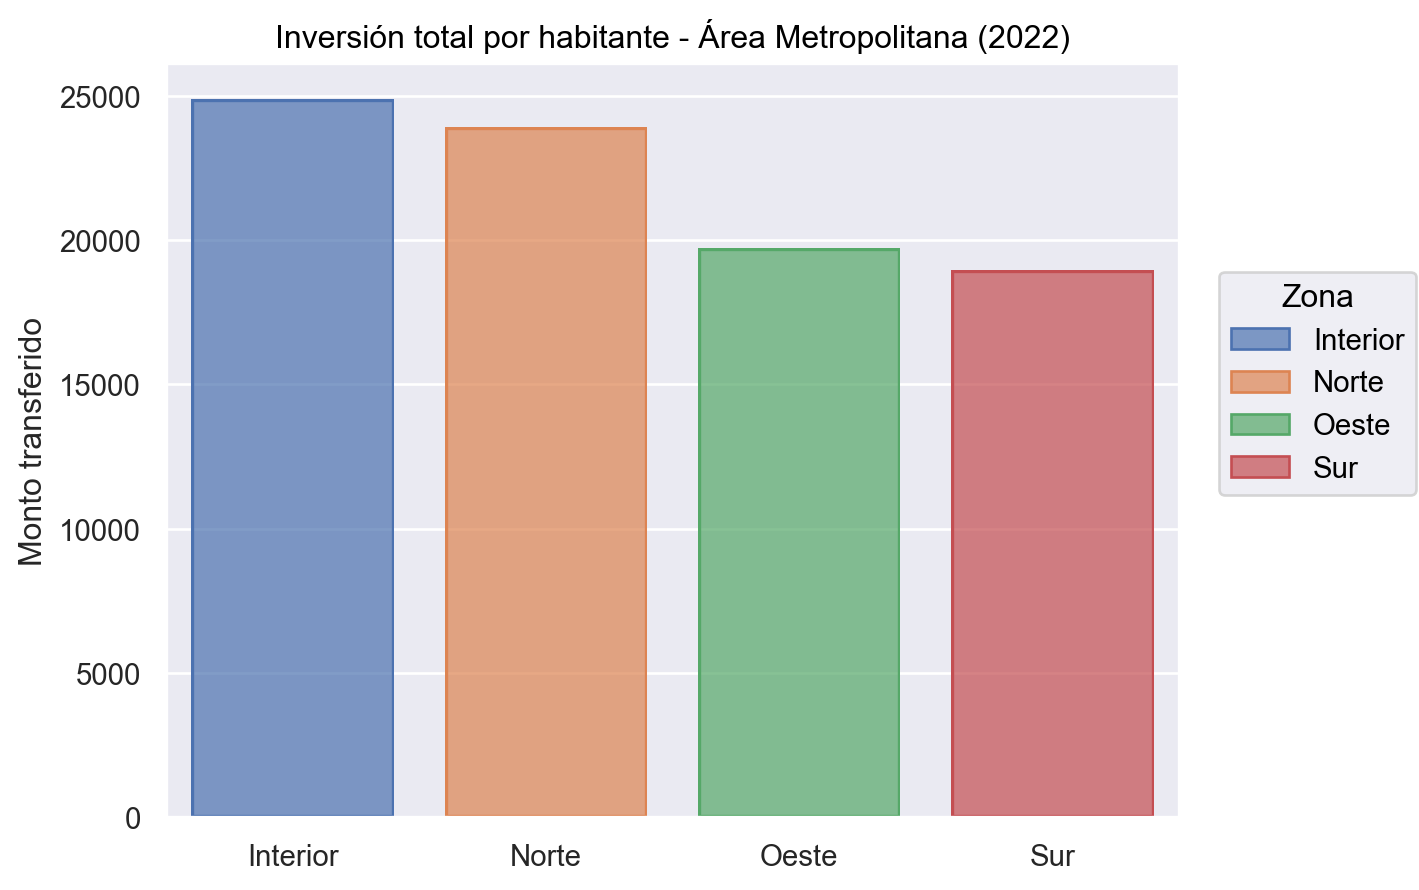

In [366]:
invserion_cada_100000=(df_zonas_2022["inversion_total"]/df_zonas_2022["poblacion"])

(so.Plot(df_zonas_2022,x="Zona",y=invserion_cada_100000,color="Zona")
    .add(so.Bar())
    .label(title="Inversión total por habitante - Área Metropolitana (2022)",x=None,y="Monto transferido"))

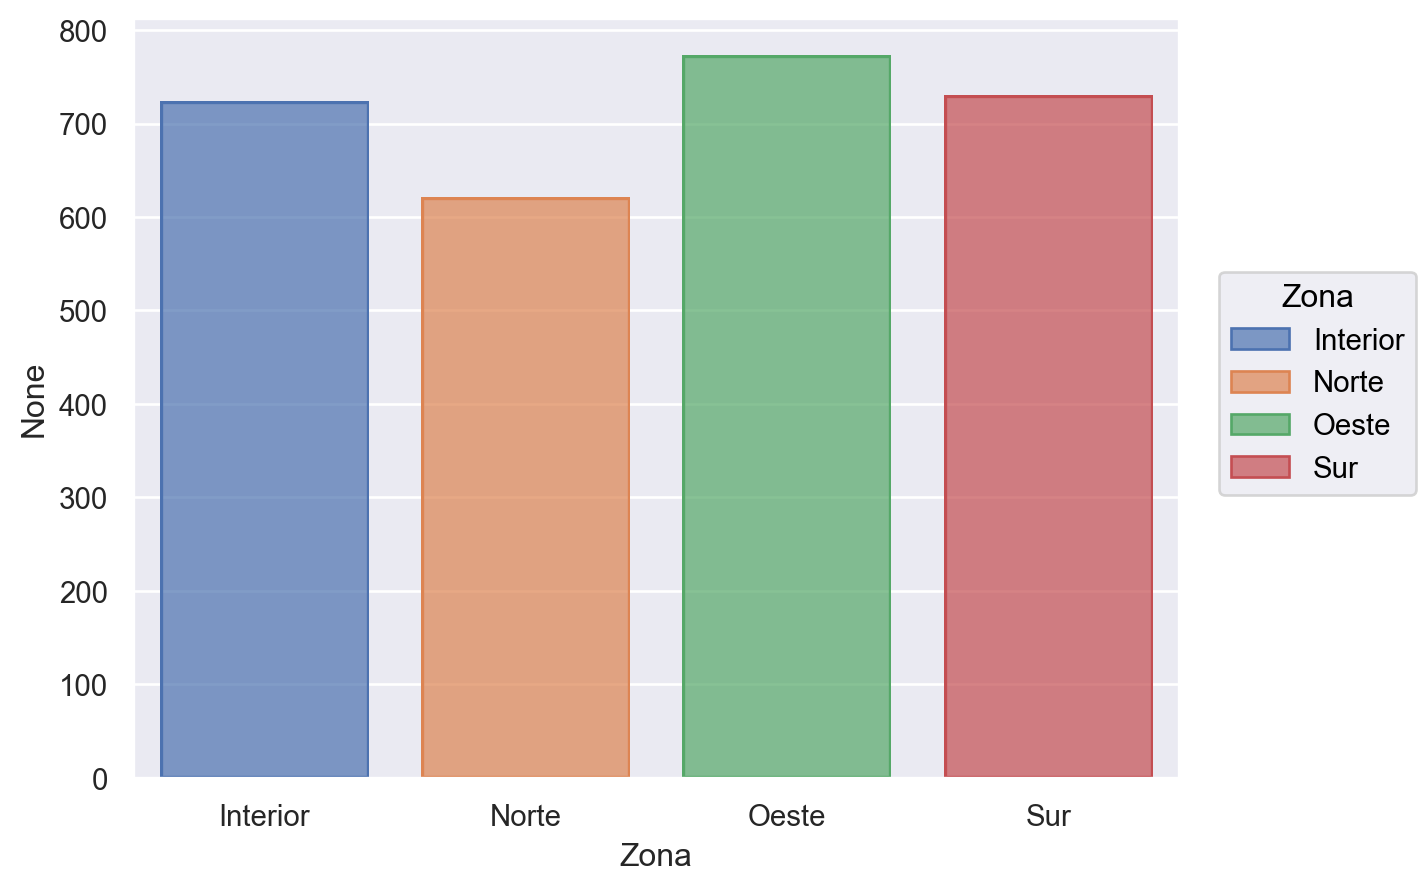

In [367]:
grafico_inversion_estudiante=((df_zonas_2022["inversion_educacion"])/(df_zonas_2022["matricula_primario"]+df_zonas_2022["matricula_nivel_inicial"]+df_zonas_2022["matricula_secundario"]))

(so.Plot(df_zonas_2022,x="Zona",y=grafico_inversion_estudiante,color="Zona")
    .add(so.Bar()))

**RESULTADO**

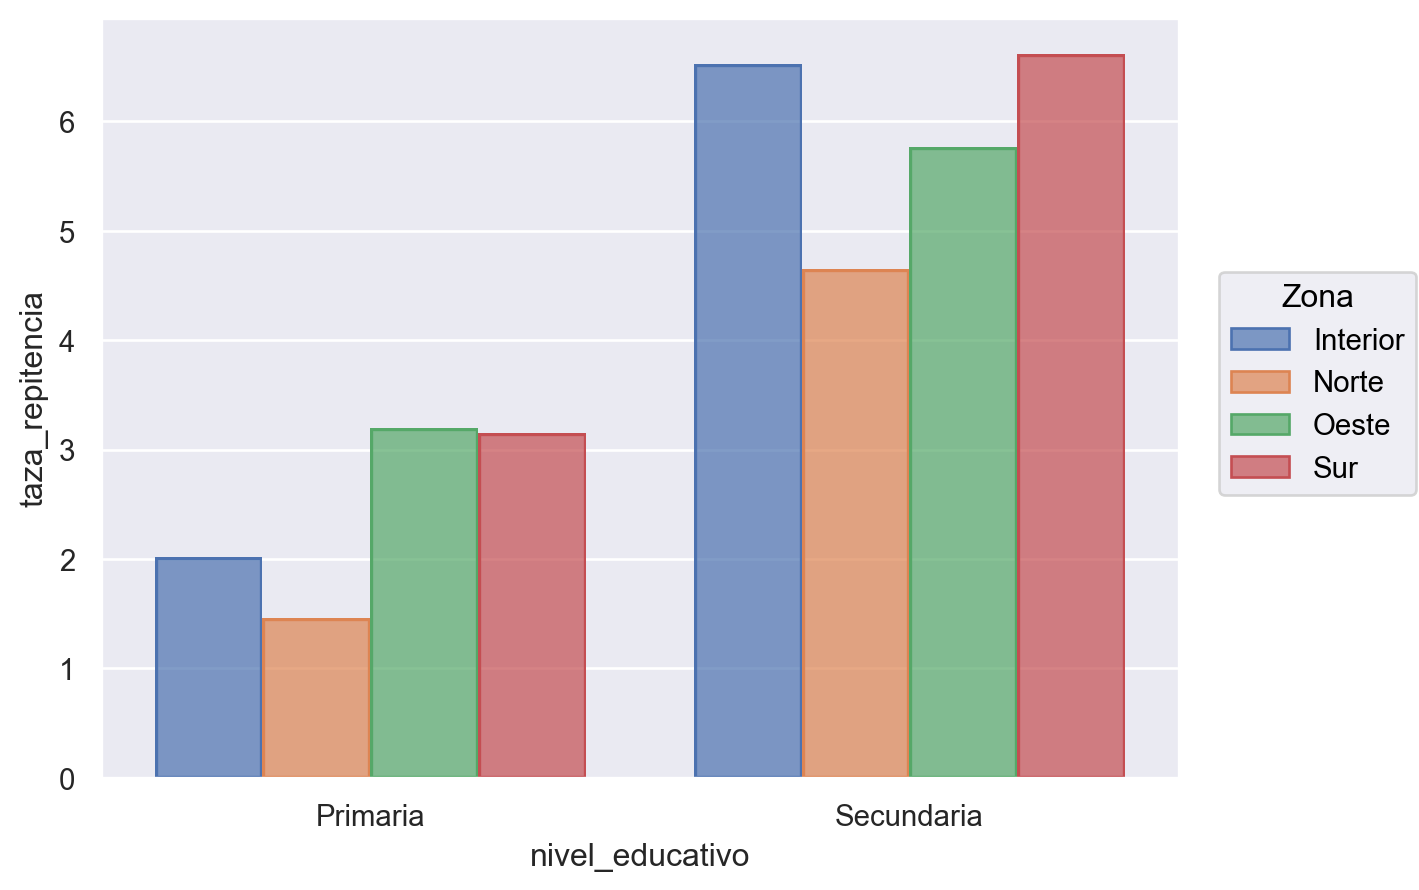

In [368]:
grafico_zona_repitencia=df_zonas_2022.copy()
grafico_zona_repitencia=grafico_zona_repitencia.rename(columns={"repitencia_secundaria":"Secundaria","repitencia_primaria":"Primaria"})
grafico_zona_repitencia=grafico_zona_repitencia.melt(id_vars="Zona",
                                            value_vars=["Primaria","Secundaria"],
                                            var_name="nivel_educativo",
                                            value_name="taza_repitencia")

(so.Plot(grafico_zona_repitencia,x="nivel_educativo",y="taza_repitencia",color="Zona")
    .add(so.Bar(),so.Dodge()))

**PROYECTO ANALITICO**

***POBLACION***

In [369]:
df_poblacion=df_poblacion[df_poblacion["municipio_nombre"].isin(area_metropolitana)]
df_poblacion=df_poblacion.loc[:,"2013":"2022"].sum().reset_index().rename(columns={"index":"anio",0:"poblacion"})
df_poblacion=df_poblacion.astype(int)

df_poblacion.head()

,anio,poblacion
0,2013,9821915
1,2014,9966956
2,2015,10110100
3,2016,10250999
4,2017,10390219


In [370]:
df_servicio

,anio,municipio_id,municipio_nombre,unidades_de_servicio_nivel_inicial*,unidades_de_servicio_nivel_primario,unidades_de_servicio_nivel_secundario**,sector_de_gestión_estatal***,sector_de_gestión_privada****,matricula_sexo_femenino*****,matricula_sexo_masculino******,matricula_nivel_inicial,matricula_nivel_primario*******,matricula_nivel_secundario********
0,2012.0,6854.0,25 de Mayo,36.0,49.0,15.0,115.0,14.0,7134.0,5952.0,2015.0,3686.0,2563.0
1,2013.0,6854.0,25 de Mayo,37.0,49.0,15.0,118.0,14.0,6805.0,5888.0,2062.0,3650.0,2588.0
2,2014.0,6854.0,25 de Mayo,38.0,49.0,15.0,120.0,14.0,6763.0,6004.0,2154.0,3621.0,2643.0
3,2015.0,6854.0,25 de Mayo,38.0,49.0,15.0,119.0,14.0,6967.0,6147.0,2105.0,3564.0,2724.0
4,2016.0,6854.0,25 de Mayo,37.0,49.0,15.0,121.0,13.0,7103.0,5994.0,2105.0,3579.0,2696.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1758,NaN,NaN,****Unidades de Servicio de Gestión Privada (t...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1759,NaN,NaN,*****Matrícula de sexo femenino (todos los Niv...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1760,NaN,NaN,******Matrícula de sexo masculino (todos los N...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1761,NaN,NaN,*******Matrícula total (Nivel primario y Modal...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


***SERVICIO***

In [371]:
df_servicio=df_servicio.dropna()
df_servicio=df_servicio.groupby("anio")[["matricula_nivel_inicial","unidades_de_servicio_nivel_primario","unidades_de_servicio_nivel_secundario**",
                             "matricula_nivel_primario*******","matricula_nivel_secundario********"]].sum().reset_index()

df_servicio["colegios_primario"]=df_servicio["matricula_nivel_primario*******"]/df_servicio["unidades_de_servicio_nivel_primario"]
df_servicio["colegios_secundario"]=df_servicio["matricula_nivel_secundario********"]/df_servicio["unidades_de_servicio_nivel_secundario**"]

df_servicio=df_servicio[(df_servicio["anio"]>=2013) & (df_servicio["anio"]<=2022)]
df_servicio=df_servicio.astype(int)
df_servicio=df_servicio.rename(columns={"matricula_nivel_primario*******":"matricula_primario","matricula_nivel_secundario********":"matricula_secundario"})
df_servicio.head()

,anio,matricula_nivel_inicial,unidades_de_servicio_nivel_primario,unidades_de_servicio_nivel_secundario**,matricula_primario,matricula_secundario,colegios_primario,colegios_secundario
2,2013,700688,5726,4315,1672887,1281572,292,297
3,2014,712783,5720,4260,1682152,1282527,294,301
4,2015,719889,5725,4216,1690161,1295252,295,307
5,2016,725600,5727,4212,1699661,1313047,296,311
6,2017,737058,5729,4183,1709261,1330950,298,318


***EDUCACION***

In [372]:
df_educacion=df_educacion[df_educacion["municipio_nombre"].isin(area_metropolitana)].reset_index(drop=True)
df_educacion=df_educacion[(df_educacion["anio"]>=2013) & (df_educacion["anio"]<=2022)]
df_educacion=df_educacion.groupby("anio").mean(numeric_only=True).reset_index()

df_educacion.head()

,anio,municipio_id,promocion_efectiva_primaria,promocion_efectiva_secundaria,repitencia_primaria,repitencia_secundaria,reinscripcion_primaria,reinscripcion_secundaria,abandono_interanual_primaria,abandono_interanual_secundaria,...,alumnos_no_promovidos_primaria,alumnos_no_promovidos_secundaria,salidos_sin_pase_primaria,salidos_sin_pase_secundaria,salidos_con_pase_primaria,salidos_con_pase_secundaria,sobreedad_primaria,sobreedad_secundaria,sobreedad_avanzada_primaria,sobreedad_avanzada_secundaria
0,2013,6446.575,97.98150,81.15725,1.58700,10.22900,0.1470,1.71675,0.28475,6.89850,...,1.43075,20.38525,0.30775,1.58325,3.6525,4.05250,11.07700,35.03250,3.00375,14.78500
1,2014,6446.575,98.02575,83.23725,1.56125,9.26175,0.1095,1.33050,0.30450,6.16925,...,1.44525,18.56675,0.26550,1.17700,3.5600,3.86675,9.20850,33.33550,2.33975,13.58800
2,2015,6446.575,97.71775,83.60475,1.91025,9.61650,0.1345,1.37900,0.23700,5.39950,...,1.78800,19.22275,0.22825,1.14250,3.5790,3.69525,7.98650,32.28125,1.91525,13.04400
3,2016,6446.575,96.13350,81.70275,3.37125,11.27975,0.1310,1.72000,0.36425,5.29800,...,2.58700,19.91900,0.20700,0.99550,3.2355,3.62975,7.52925,31.82275,1.62950,12.88925
4,2017,6446.575,96.10400,83.11350,3.45025,11.22525,0.1060,1.38475,0.34100,4.27825,...,2.44625,18.54525,0.20075,0.88650,3.2910,3.47650,7.13825,30.95750,1.54925,12.44750


***TRANSFERENCIAS***

In [373]:
fondo_financiamiento=df_transferencias[df_transferencias["municipio_nombre"].isin(area_metropolitana)]
fondo_financiamiento=fondo_financiamiento[(fondo_financiamiento["anio"]>=2013) & (fondo_financiamiento["anio"]<=2022)]
fondo_financiamiento=fondo_financiamiento[fondo_financiamiento["concepto"]=="Fondo Financiamiento Educativo"]

fondo_financiamiento=fondo_financiamiento.groupby("anio")["monto"].sum().reset_index()
fondo_financiamiento=fondo_financiamiento.rename(columns={"monto":"inversion_educativa"})

fondo_financiamiento.head()

,anio,inversion_educativa
0,2013,5.216849e+08
1,2014,6.647231e+08
2,2015,1.607878e+09
3,2016,2.102110e+09
4,2017,2.525195e+09


In [374]:
df_transferencias=df_transferencias[df_transferencias["municipio_nombre"].isin(area_metropolitana)]
df_transferencias=df_transferencias[(df_transferencias["anio"]>=2013) & (df_transferencias["anio"]<=2022)]

df_transferencias=df_transferencias[df_transferencias["concepto"].isin(["Fondo Financiamiento Educativo","Fondo Inclusión Social","Fondo Infraestructura Municipal"])]
df_transferencias=df_transferencias.groupby("anio")["monto"].sum().reset_index()
df_transferencias=df_transferencias.rename(columns={"monto":"inversion_total"})

df_transferencias.head()

,anio,inversion_total
0,2013,5.216849e+08
1,2014,6.647231e+08
2,2015,1.607878e+09
3,2016,4.523040e+09
4,2017,2.525195e+09


In [375]:
df_transferencias=pd.merge(df_transferencias,fondo_financiamiento,on="anio",how="inner")
df_transferencias

,anio,inversion_total,inversion_educativa
0,2013,5.216849e+08,5.216849e+08
1,2014,6.647231e+08,6.647231e+08
2,2015,1.607878e+09,1.607878e+09
3,2016,4.523040e+09,2.102110e+09
4,2017,2.525195e+09,2.525195e+09
5,2018,3.341650e+09,3.341650e+09
6,2019,5.186188e+09,5.186188e+09
7,2020,6.247266e+09,6.247266e+09
8,2021,1.068350e+10,1.068350e+10
9,2022,2.060192e+10,1.744377e+10


In [376]:
#MERGEO EL PRIMER DATA SET 
df_investigacion=df_poblacion.copy()
#Mergeo servicio
df_investigacion=pd.merge(df_investigacion,df_servicio,on="anio",how="inner")
#Mergeo educacion
df_investigacion=pd.merge(df_investigacion,df_educacion,on="anio",how="inner")
#Mergeo transferencias
df_investigacion=pd.merge(df_investigacion,df_transferencias,on="anio",how="inner")

df_investigacion.head()

,anio,poblacion,matricula_nivel_inicial,unidades_de_servicio_nivel_primario,unidades_de_servicio_nivel_secundario**,matricula_primario,matricula_secundario,colegios_primario,colegios_secundario,municipio_id,...,salidos_sin_pase_primaria,salidos_sin_pase_secundaria,salidos_con_pase_primaria,salidos_con_pase_secundaria,sobreedad_primaria,sobreedad_secundaria,sobreedad_avanzada_primaria,sobreedad_avanzada_secundaria,inversion_total,inversion_educativa
0,2013,9821915,700688,5726,4315,1672887,1281572,292,297,6446.575,...,0.30775,1.58325,3.6525,4.05250,11.07700,35.03250,3.00375,14.78500,5.216849e+08,5.216849e+08
1,2014,9966956,712783,5720,4260,1682152,1282527,294,301,6446.575,...,0.26550,1.17700,3.5600,3.86675,9.20850,33.33550,2.33975,13.58800,6.647231e+08,6.647231e+08
2,2015,10110100,719889,5725,4216,1690161,1295252,295,307,6446.575,...,0.22825,1.14250,3.5790,3.69525,7.98650,32.28125,1.91525,13.04400,1.607878e+09,1.607878e+09
3,2016,10250999,725600,5727,4212,1699661,1313047,296,311,6446.575,...,0.20700,0.99550,3.2355,3.62975,7.52925,31.82275,1.62950,12.88925,4.523040e+09,2.102110e+09
4,2017,10390219,737058,5729,4183,1709261,1330950,298,318,6446.575,...,0.20075,0.88650,3.2910,3.47650,7.13825,30.95750,1.54925,12.44750,2.525195e+09,2.525195e+09


**GRAFICOS**

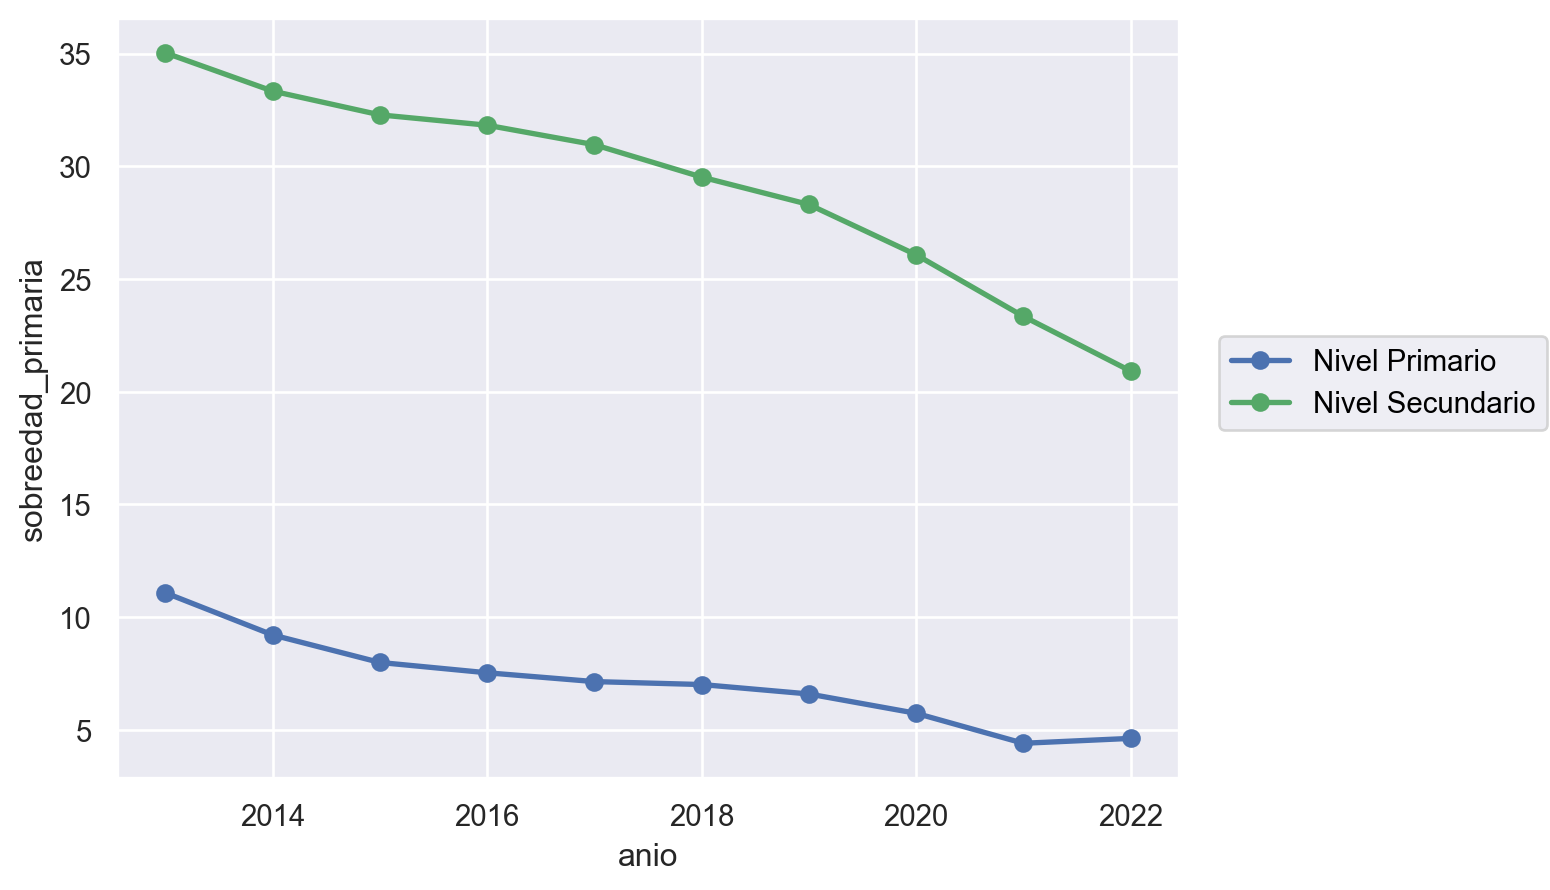

In [377]:
(so.Plot(df_investigacion,x="anio")
    .add(so.Line(marker="o",color="b",linewidth=2),y="sobreedad_primaria",label="Nivel Primario")
    .add(so.Line(marker="o",color="C2",linewidth=2),y="sobreedad_secundaria",label="Nivel Secundario"))

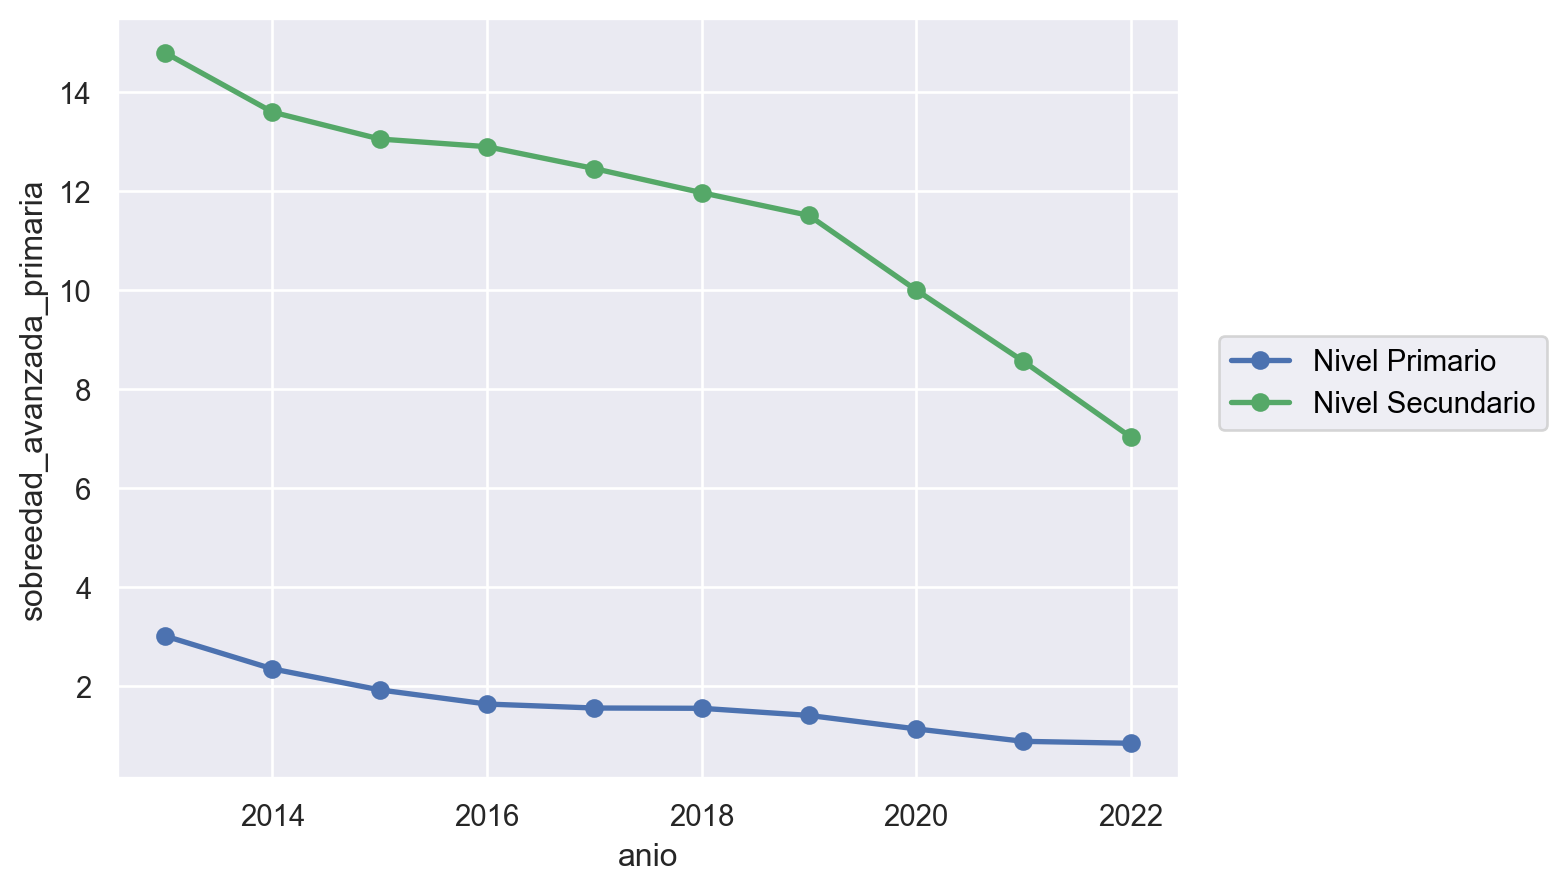

In [378]:
(so.Plot(df_investigacion,x="anio")
    .add(so.Line(marker="o",color="b",linewidth=2),y="sobreedad_avanzada_primaria",label="Nivel Primario")
    .add(so.Line(marker="o",color="C2",linewidth=2),y="sobreedad_avanzada_secundaria",label="Nivel Secundario"))

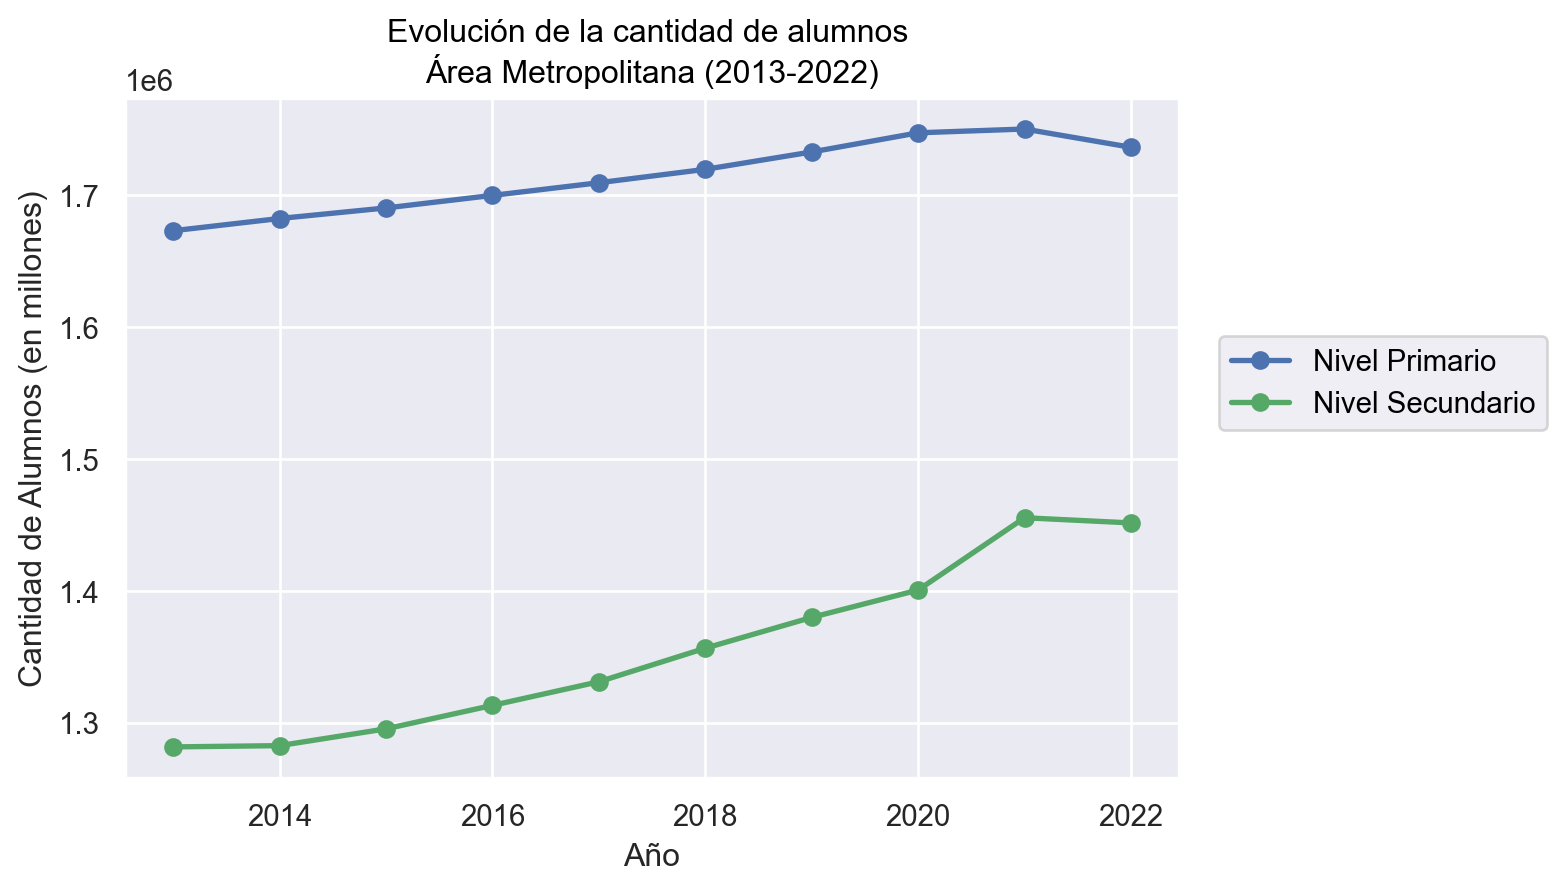

In [379]:
(so.Plot(df_investigacion,x="anio")
    .add(so.Line(marker="o",color="b",linewidth=2),y="matricula_primario",label="Nivel Primario")
    .add(so.Line(marker="o",color="C2",linewidth=2),y="matricula_secundario",label="Nivel Secundario")
    .label(title="Evolución de la cantidad de alumnos \nÁrea Metropolitana (2013-2022)",x="Año",y="Cantidad de Alumnos (en millones)"))

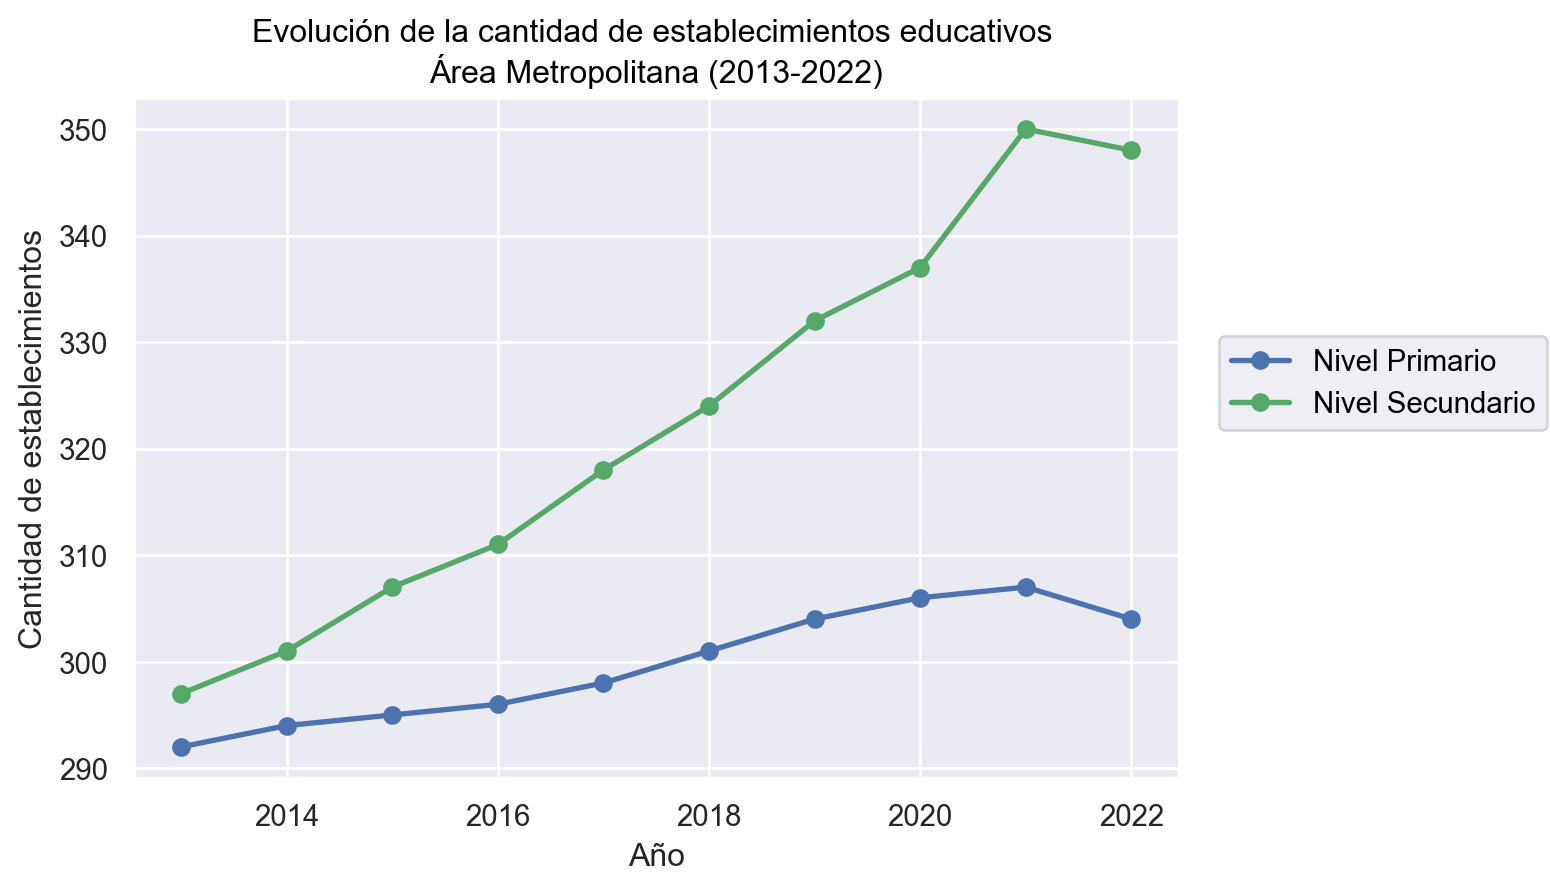

In [380]:
(so.Plot(df_investigacion,x="anio")
    .add(so.Line(marker="o",color="b",linewidth=2),y="colegios_primario",label="Nivel Primario")
    .add(so.Line(marker="o",color="C2",linewidth=2),y="colegios_secundario",label="Nivel Secundario")
    .label(title="Evolución de la cantidad de establecimientos educativos \nÁrea Metropolitana (2013-2022)",x="Año",y="Cantidad de establecimientos"))

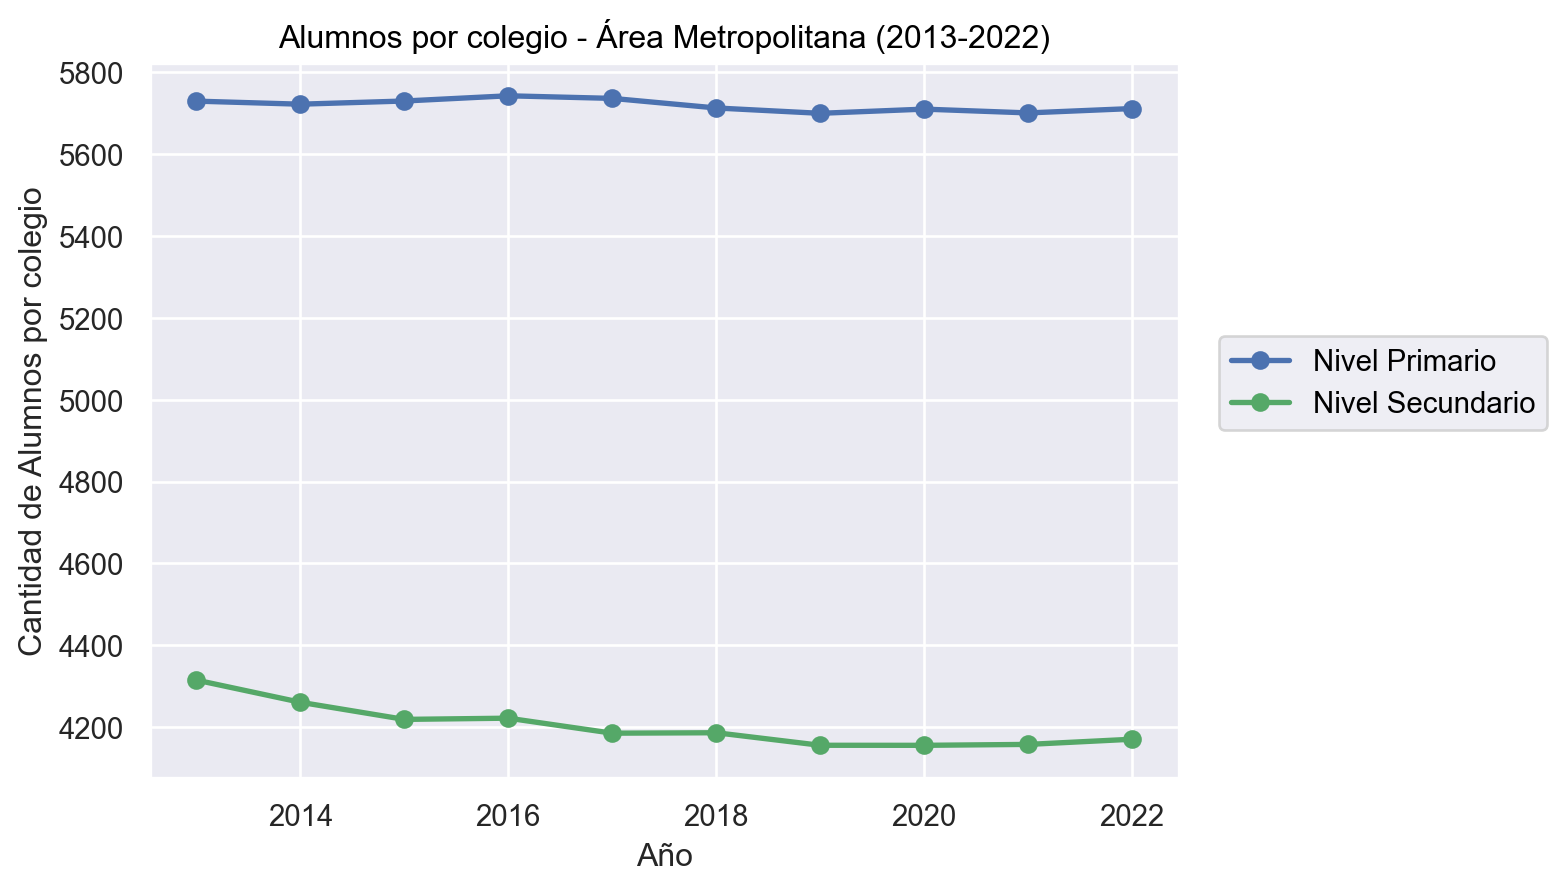

In [381]:
(so.Plot(df_investigacion,x="anio")
    .add(so.Line(marker="o",color="b",linewidth=2),y=df_investigacion["matricula_primario"]/df_investigacion["colegios_primario"],label="Nivel Primario")
    .add(so.Line(marker="o",color="C2",linewidth=2),y=df_investigacion["matricula_secundario"]/df_investigacion["colegios_secundario"],label="Nivel Secundario")
    .label(title="Alumnos por colegio - Área Metropolitana (2013-2022)",x="Año",y="Cantidad de Alumnos por colegio"))

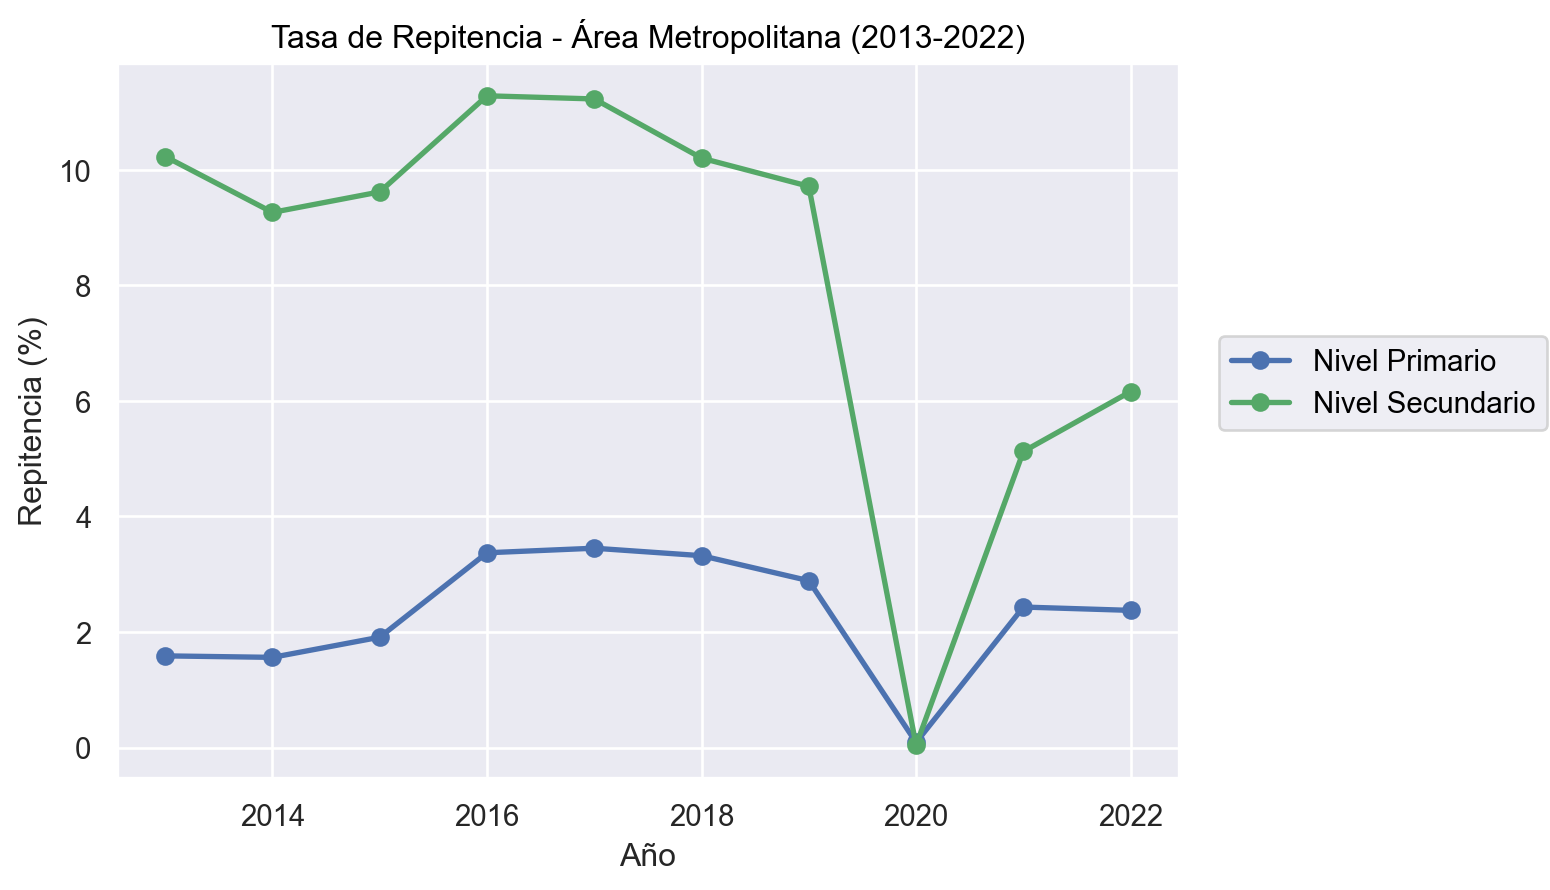

In [382]:
(so.Plot(df_investigacion,x="anio")
    .add(so.Line(marker="o",color="b",linewidth=2),y="repitencia_primaria",label="Nivel Primario")
    .add(so.Line(marker="o",color="C2",linewidth=2),y="repitencia_secundaria",label="Nivel Secundario")    
    .label(title="Tasa de Repitencia - Área Metropolitana (2013-2022)",y="Repitencia (%)",x="Año"))

In [383]:
df_investigacion

,anio,poblacion,matricula_nivel_inicial,unidades_de_servicio_nivel_primario,unidades_de_servicio_nivel_secundario**,matricula_primario,matricula_secundario,colegios_primario,colegios_secundario,municipio_id,...,salidos_sin_pase_primaria,salidos_sin_pase_secundaria,salidos_con_pase_primaria,salidos_con_pase_secundaria,sobreedad_primaria,sobreedad_secundaria,sobreedad_avanzada_primaria,sobreedad_avanzada_secundaria,inversion_total,inversion_educativa
0,2013,9821915,700688,5726,4315,1672887,1281572,292,297,6446.575,...,0.30775,1.58325,3.65250,4.05250,11.07700,35.03250,3.00375,14.78500,5.216849e+08,5.216849e+08
1,2014,9966956,712783,5720,4260,1682152,1282527,294,301,6446.575,...,0.26550,1.17700,3.56000,3.86675,9.20850,33.33550,2.33975,13.58800,6.647231e+08,6.647231e+08
2,2015,10110100,719889,5725,4216,1690161,1295252,295,307,6446.575,...,0.22825,1.14250,3.57900,3.69525,7.98650,32.28125,1.91525,13.04400,1.607878e+09,1.607878e+09
3,2016,10250999,725600,5727,4212,1699661,1313047,296,311,6446.575,...,0.20700,0.99550,3.23550,3.62975,7.52925,31.82275,1.62950,12.88925,4.523040e+09,2.102110e+09
4,2017,10390219,737058,5729,4183,1709261,1330950,298,318,6446.575,...,0.20075,0.88650,3.29100,3.47650,7.13825,30.95750,1.54925,12.44750,2.525195e+09,2.525195e+09
5,2018,10527540,749145,5701,4179,1719419,1356407,301,324,6446.575,...,0.13825,0.62800,3.35825,3.54150,7.00775,29.52175,1.54375,11.96050,3.341650e+09,3.341650e+09
6,2019,10663072,746605,5696,4154,1732589,1379741,304,332,6446.575,...,0.12125,0.55550,3.30250,3.29000,6.58975,28.30425,1.40000,11.50125,5.186188e+09,5.186188e+09
7,2020,10796674,724236,5694,4147,1747120,1400479,306,337,6446.575,...,0.05000,0.15350,3.36825,3.03600,5.73125,26.07375,1.12775,9.99475,6.247266e+09,6.247266e+09
8,2021,10927837,673214,5690,4150,1749991,1455289,307,350,6446.575,...,0.06650,0.20950,1.64025,1.27425,4.40150,23.34150,0.87625,8.55400,1.068350e+10,1.068350e+10
9,2022,10459888,678571,5699,4160,1736132,1451378,304,348,6446.575,...,0.07125,0.29275,3.18500,2.47125,4.61875,20.91575,0.83700,7.02525,2.060192e+10,1.744377e+10


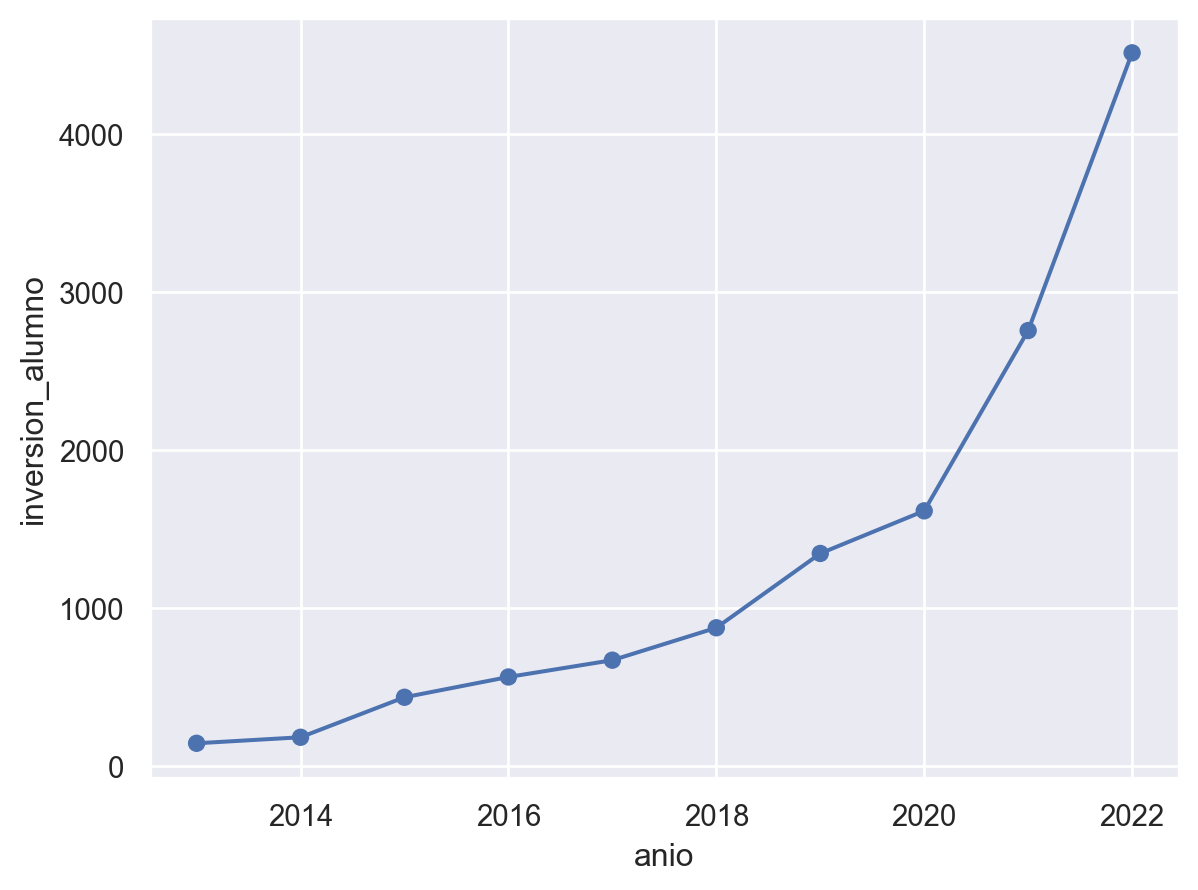

In [384]:
df_investigacion["matricula_total"]=df_investigacion["matricula_primario"]+df_investigacion["matricula_secundario"]+df_investigacion["matricula_nivel_inicial"]
df_investigacion["inversion_alumno"]=(df_investigacion["inversion_educativa"]/df_investigacion["matricula_total"])
df_investigacion["inversion_total_total"]=(df_investigacion["inversion_total"]/df_investigacion["poblacion"])

(so.Plot(df_investigacion,x="anio",y="inversion_alumno")
    .add(so.Line())
    .add(so.Dot()))


**PREDICCION REPITENCIA**

**KFOLD VALIDATION**

**“Dado el tamaño reducido de la serie temporal, se utilizó TimeSeriesSplit con pocos folds para asegurar conjuntos de entrenamiento informativos y evitar inestabilidad en los primeros splits.”**

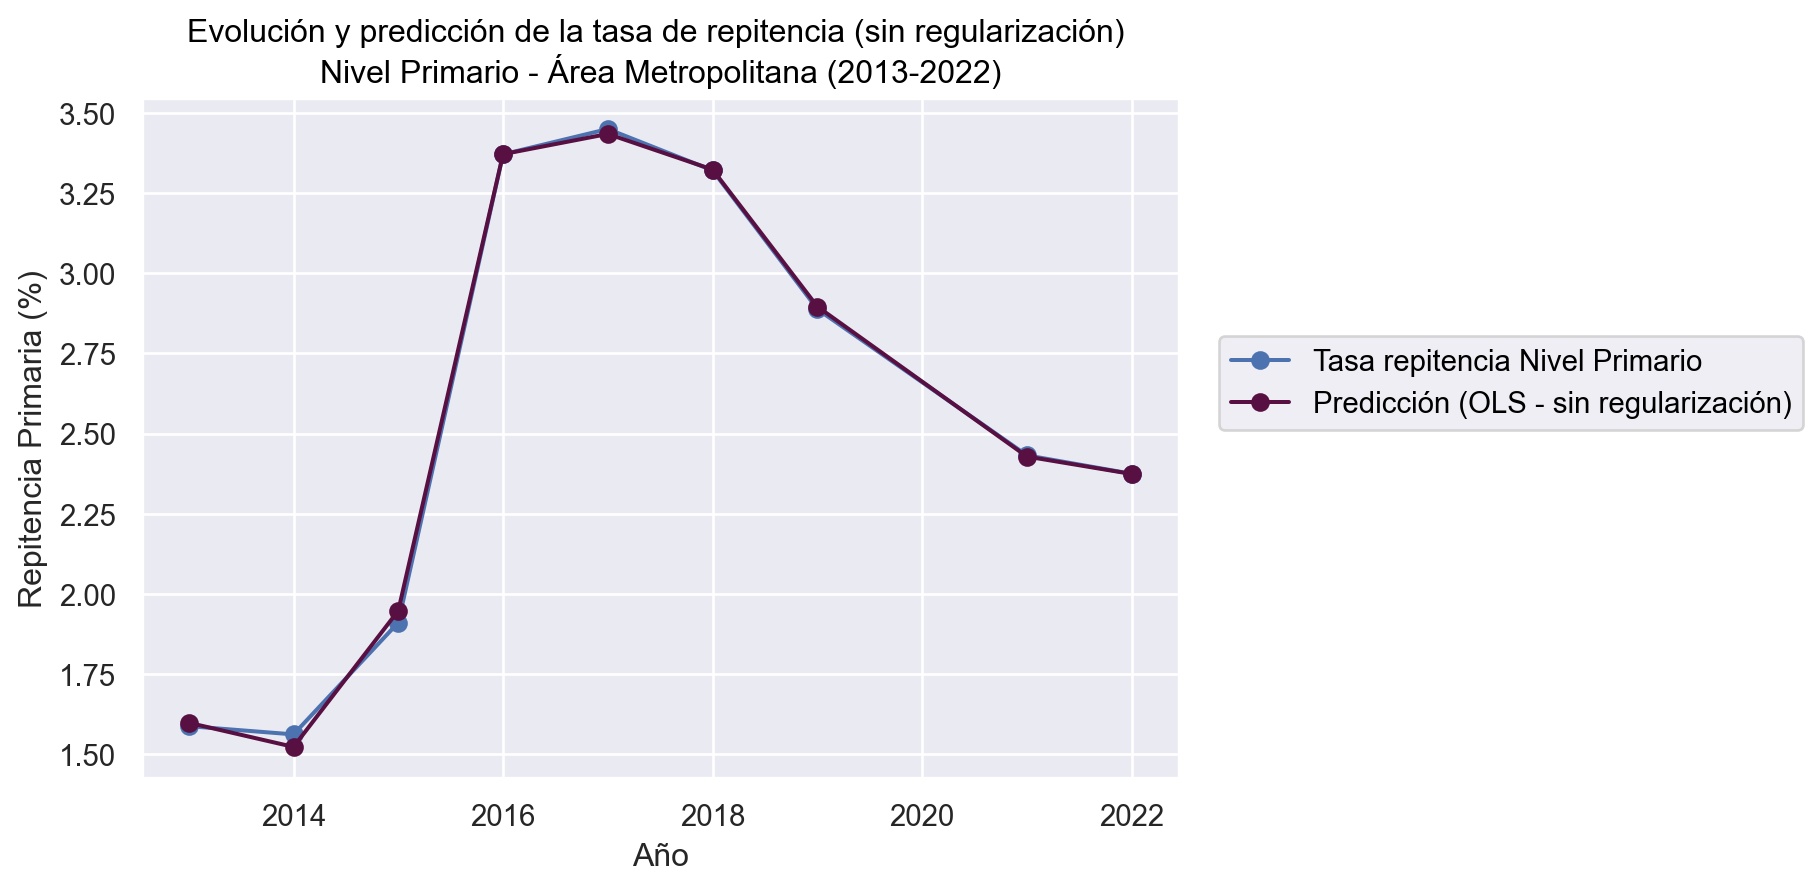

In [385]:
df_investigacion=df_investigacion[df_investigacion["anio"]!=2020].copy()

y,X=Formula('repitencia_primaria ~ anio + unidades_de_servicio_nivel_primario + matricula_primario + inversion_alumno + inversion_total_total + sobreedad_primaria + sobreedad_avanzada_primaria').get_model_matrix(df_investigacion)
modelo=linear_model.LinearRegression(fit_intercept=False)
modelo.fit(X,y)

y_pred=modelo.predict(X)
df_investigacion["pred_repitencia"]=y_pred

(so.Plot(df_investigacion,x="anio")
    .add(so.Line(color="b",marker="o"),y="repitencia_primaria",label="Tasa repitencia Nivel Primario")
    .add(so.Line(color="xkcd:plum",marker="o"),y="pred_repitencia",label="Predicción (OLS - sin regularización)")
    .label(title="Evolución y predicción de la tasa de repitencia (sin regularización) \nNivel Primario - Área Metropolitana (2013-2022)",x="Año",y="Repitencia Primaria (%)"))

In [386]:
tscv = TimeSeriesSplit(n_splits=3)

alphas = np.arange(0,50,1)
error_alphas=np.zeros(len(alphas))

for counter,alpha in enumerate(alphas):
    rmse = np.zeros(tscv.get_n_splits())
    modeloRidge=linear_model.Ridge(alpha=alpha,fit_intercept=False)
    ind=0

    for train_index, val_index in tscv.split(X):
        X_train, X_val, y_train, y_val=X.iloc[train_index],X.iloc[val_index],y.iloc[train_index],y.iloc[val_index]
        modeloRidge.fit(X_train,y_train)

        y_pred=modeloRidge.predict(X_val)
        rmse[ind]=np.sqrt(mean_squared_error(y_val,y_pred))
        ind=ind+1 
    error_alphas[counter] = np.median(rmse)

error_alphas

c:\Users\franc\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\_lib\_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.8963e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


array([1.25738242, 1.25735352, 1.25732482, 1.25729623, 1.25726776,
       1.25723946, 1.31011803, 1.36258246, 1.40477878, 1.43953975,
       1.46860629, 1.4932839 , 1.51454678, 1.53299348, 1.54917547,
       1.56346729, 1.57624255, 1.58769127, 1.5980003 , 1.60733205,
       1.61583123, 1.62364208, 1.6307709 , 1.63738367, 1.64347744,
       1.64912445, 1.65436706, 1.6592916 , 1.66387424, 1.66816048,
       1.67220312, 1.67600827, 1.6795836 , 1.68298222, 1.68617258,
       1.68921071, 1.69208663, 1.69482253, 1.69743979, 1.69991431,
       1.70229502, 1.70455717, 1.70672623, 1.70879981, 1.71078936,
       1.71270257, 1.71453011, 1.71628986, 1.71798581, 1.71962671])

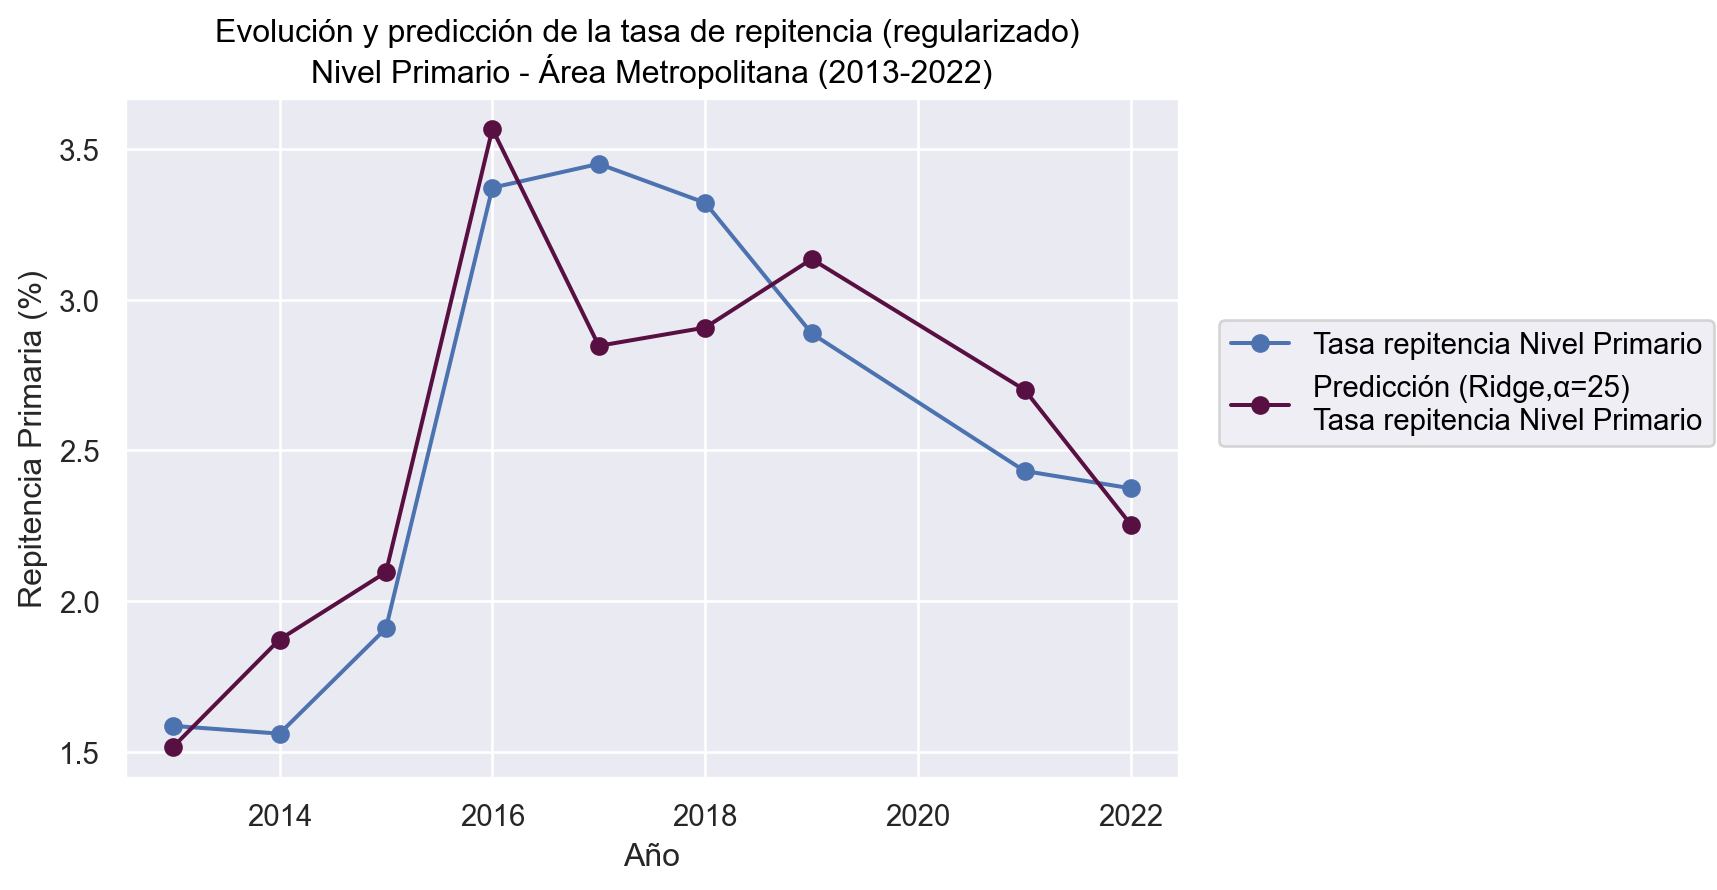

In [387]:
alpha_optimo=alphas[25]
y,X=Formula('repitencia_primaria ~ anio + unidades_de_servicio_nivel_primario + matricula_primario + inversion_total_total+ inversion_alumno + sobreedad_primaria + sobreedad_avanzada_primaria').get_model_matrix(df_investigacion)
modelo=linear_model.Ridge(alpha=alpha_optimo,fit_intercept=False)
modelo.fit(X,y)

y_pred=modelo.predict(X)
df_investigacion["pred_repitencia"]=y_pred

(so.Plot(df_investigacion,x="anio")
    .add(so.Line(color="b",marker="o"),y="repitencia_primaria",label="Tasa repitencia Nivel Primario")
    .add(so.Line(color="xkcd:plum",marker="o"),y="pred_repitencia",label="Predicción (Ridge,α=25) \nTasa repitencia Nivel Primario")
    .label(title="Evolución y predicción de la tasa de repitencia (regularizado) \nNivel Primario - Área Metropolitana (2013-2022)",x="Año",y="Repitencia Primaria (%)"))

In [388]:
print(r2_score(y,y_pred))

0.8116298049743067


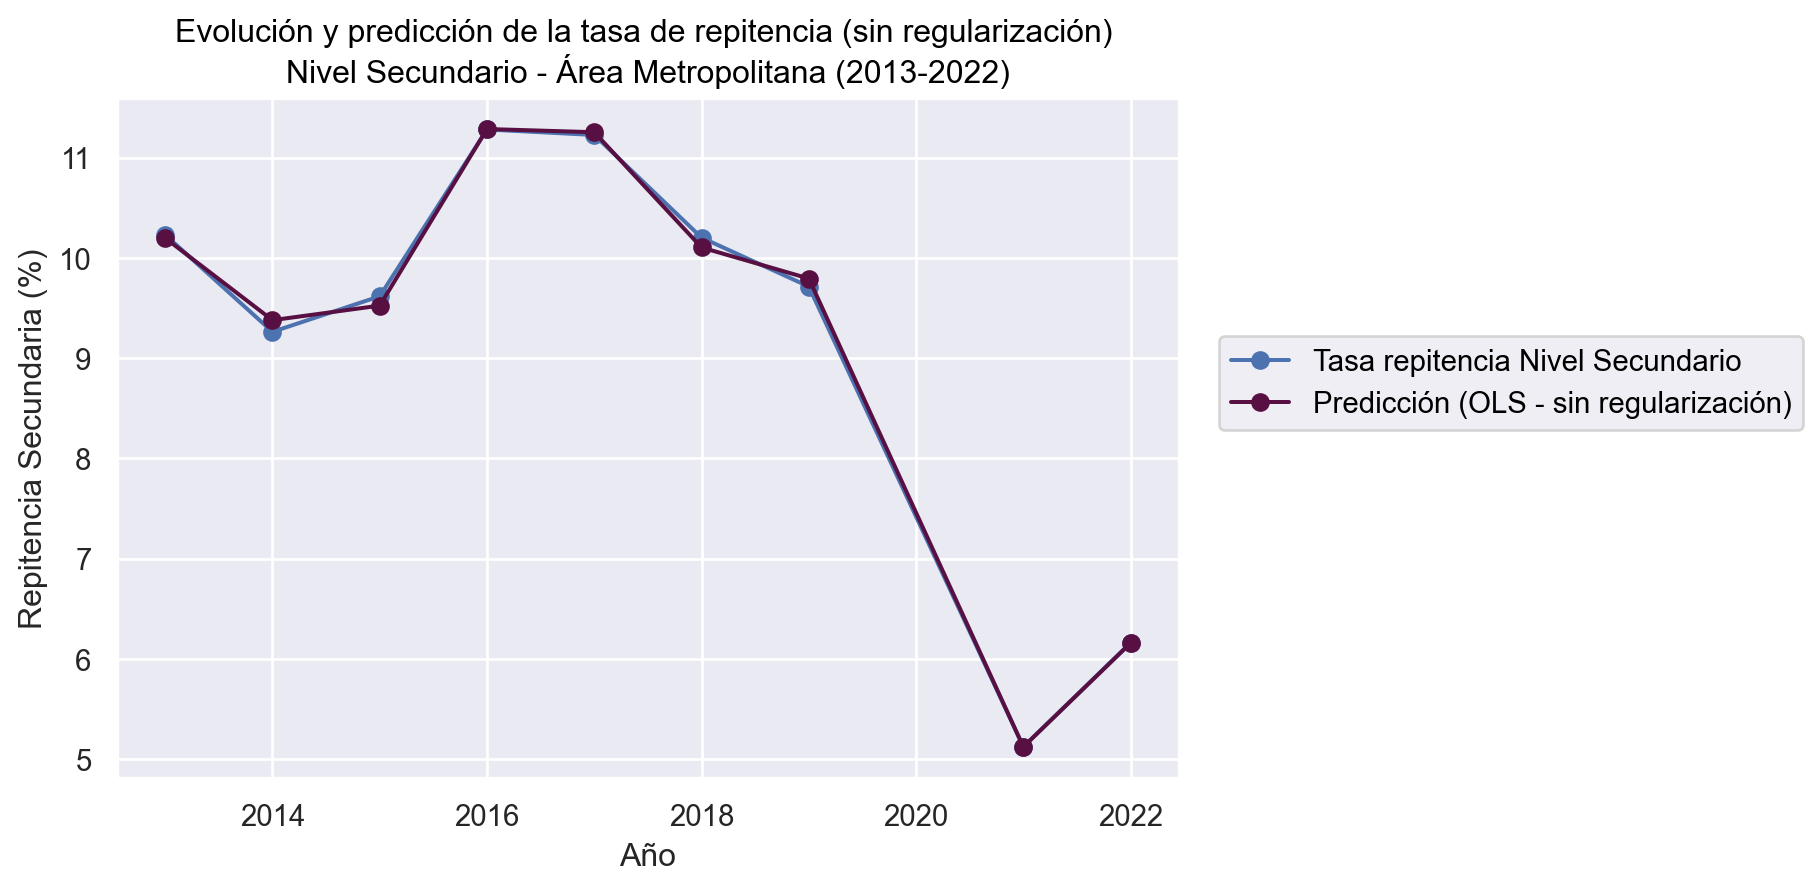

In [389]:
df_investigacion=df_investigacion.rename(columns={"unidades_de_servicio_nivel_secundario**":"unidades_servicio_secundario"})

y,X=Formula('repitencia_secundaria ~ anio + unidades_servicio_secundario + matricula_secundario + inversion_alumno +inversion_total_total + sobreedad_secundaria + sobreedad_avanzada_secundaria').get_model_matrix(df_investigacion)
modelo=linear_model.LinearRegression(fit_intercept=False)
modelo.fit(X,y)

y_pred=modelo.predict(X)
df_investigacion["pred_repitencia"]=y_pred

(so.Plot(df_investigacion,x="anio")
    .add(so.Line(color="b",marker="o"),y="repitencia_secundaria",label="Tasa repitencia Nivel Secundario")
    .add(so.Line(color="xkcd:plum",marker="o"),y="pred_repitencia",label="Predicción (OLS - sin regularización)")
    .label(title="Evolución y predicción de la tasa de repitencia (sin regularización) \nNivel Secundario - Área Metropolitana (2013-2022)",x="Año",y="Repitencia Secundaria (%)"))

In [390]:
tscv = TimeSeriesSplit(n_splits=3)

alphas = np.arange(0,100,1)
error_alphas=np.zeros(len(alphas))

for counter,alpha in enumerate(alphas):
    rmse = np.zeros(tscv.get_n_splits())
    modeloRidge=linear_model.Ridge(alpha=alpha,fit_intercept=False)
    ind=0

    for train_index, val_index in tscv.split(X):
        X_train, X_val, y_train, y_val=X.iloc[train_index],X.iloc[val_index],y.iloc[train_index],y.iloc[val_index]
        modeloRidge.fit(X_train,y_train)

        y_pred=modeloRidge.predict(X_val)
        rmse[ind]=np.sqrt(mean_squared_error(y_val,y_pred))
        ind=ind+1
    error_alphas[counter] = np.median(rmse)
error_alphas

array([3.94447436, 3.93515446, 3.92592392, 3.91677994, 3.90772206,
       3.89875114, 3.8898621 , 3.88105999, 3.87233486, 3.86369124,
       3.85513112, 3.84664225, 3.83823526, 3.82990696, 3.82165157,
       3.81346976, 3.8053626 , 3.79732684, 3.78936374, 3.78147198,
       3.77364848, 3.76589139, 3.758206  , 3.75058313, 3.74303324,
       3.73554074, 3.72811712, 3.72075837, 3.71345672, 3.70621807,
       3.69904658, 3.6919321 , 3.68487691, 3.67788163, 3.67094119,
       3.66405848, 3.65723943, 3.65046784, 3.6437574 , 3.63710193,
       3.63049621, 3.62394634, 3.61744962, 3.6110054 , 3.60461103,
       3.59826905, 3.5919766 , 3.5857366 , 3.5795421 , 3.57339429,
       3.56729955, 3.56125186, 3.55524603, 3.54929092, 3.54338342,
       3.53751793, 3.53169683, 3.52592155, 3.52019186, 3.51450414,
       3.50885693, 3.50325321, 3.49769506, 3.49217285, 3.48669379,
       3.481256  , 3.47585811, 3.47049921, 3.46518006, 3.45989888,
       3.45465719, 3.4494535 , 3.44428729, 3.4391576 , 3.43406

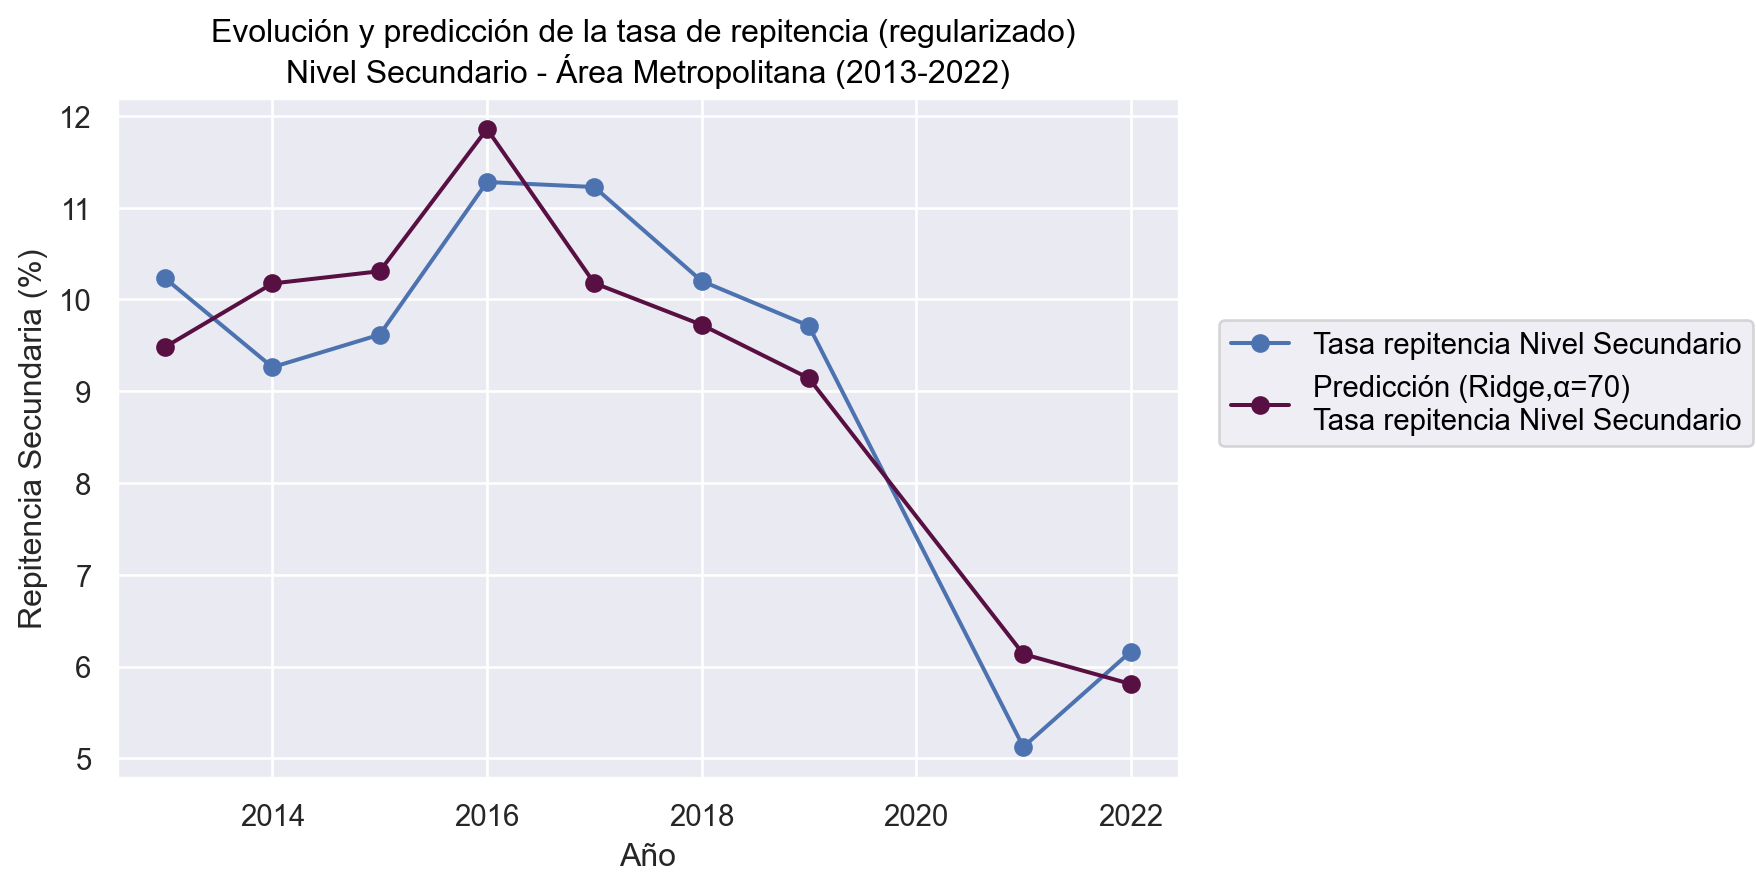

In [391]:
alpha_optimo=alphas[70]

y,X=Formula('repitencia_secundaria ~ anio + unidades_servicio_secundario + matricula_secundario + inversion_alumno + inversion_total_total + sobreedad_secundaria + sobreedad_avanzada_secundaria').get_model_matrix(df_investigacion)
modelo=linear_model.Ridge(alpha=alpha_optimo,fit_intercept=False)
modelo.fit(X,y)

y_pred=modelo.predict(X)
df_investigacion["pred_repitencia"]=y_pred

(so.Plot(df_investigacion,x="anio")
    .add(so.Line(color="b",marker="o"),y="repitencia_secundaria",label="Tasa repitencia Nivel Secundario")
    .add(so.Line(color="xkcd:plum",marker="o"),y="pred_repitencia",label="Predicción (Ridge,α=70) \nTasa repitencia Nivel Secundario")
    .label(title="Evolución y predicción de la tasa de repitencia (regularizado) \nNivel Secundario - Área Metropolitana (2013-2022)",x="Año",y="Repitencia Secundaria (%)"))

In [392]:
r2_score(y,y_pred)

0.8641166958397055

In [400]:
df_train=df_investigacion[df_investigacion["anio"]<=2019]
df_test=df_investigacion[df_investigacion["anio"]>2019] 

In [402]:
alpha_optimo=alphas[70]

y,X=Formula('repitencia_secundaria ~ anio + unidades_servicio_secundario + matricula_secundario + inversion_alumno + inversion_total_total + sobreedad_secundaria + sobreedad_avanzada_secundaria').get_model_matrix(df_train)
modelo=linear_model.Ridge(alpha=alpha_optimo,fit_intercept=False)
modelo.fit(X,y)

y1,X1=Formula('repitencia_secundaria ~ anio + unidades_servicio_secundario + matricula_secundario + inversion_alumno + inversion_total_total + sobreedad_secundaria + sobreedad_avanzada_secundaria').get_model_matrix(df_test)

y_pred=modelo.predict(X1)
r2_score(y1,y_pred)

-49.123825702761174